In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [3]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

c:\Users\Shafakat Arnob\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
ROOT_DIR = './'

df_org= pd.read_csv(ROOT_DIR + "fifa_world_cup_2022_tweets.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral


In [7]:
df_org.drop('Unnamed: 0',axis=1, inplace=True)
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral
...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive


In [8]:
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# download(['punkt','vader_lexicon'])

Sentiment
negative    5784
neutral     8251
positive    8489
Name: count, dtype: int64


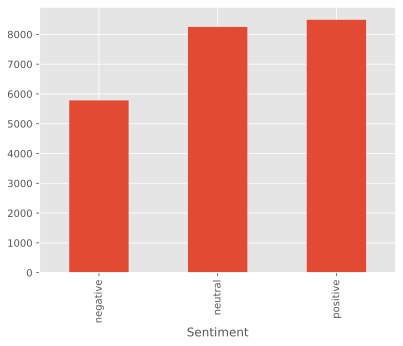

In [9]:
print(df_org['Sentiment'].value_counts().sort_index())
df_org['Sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [10]:
# using regex to clean the tweets, removing usernames, urls, stopwords, etc.
def preprocess(text):
    text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
    text = re.sub(r'\bhttps?://\S+\b', 'http', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [21]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [11]:
df_org['preprocessed_tweet'] = df_org['Tweet'].apply(preprocess)

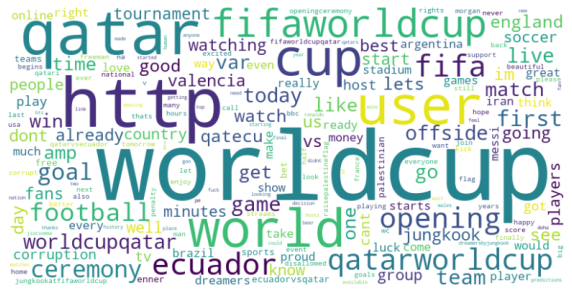

In [12]:
# Calculate word frequencies
word_freq = df_org['preprocessed_tweet'].str.split().explode().value_counts().reset_index()
word_freq.columns = ['Word', 'Frequency']
word_freq['Frequency'] = word_freq['Frequency'].astype(int)  # Convert frequency column to integers

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.set_index('Word')['Frequency'].to_dict())

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
labels = df_org['Sentiment'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['neutral', 'negative', 'positive']

In [14]:
for key, value in enumerate(labels):
    print(value)

neutral
negative
positive


In [15]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [16]:
label2id

{'neutral': 0, 'negative': 1, 'positive': 2}

In [17]:
id2label

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [18]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup
...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...


In [19]:
df_org["labels"]=df_org['Sentiment'].map(lambda x: label2id[x.strip()])

In [20]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,labels
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...,0
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup,1
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...,0
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...,0
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup,0
...,...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...,1
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...,2
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...,0
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...,2


<Axes: ylabel='count'>

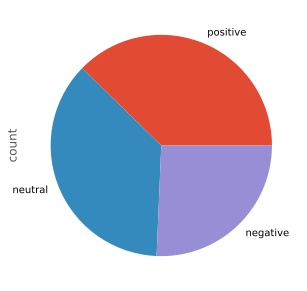

In [21]:
df_org['Sentiment'].value_counts().plot(kind='pie', figsize=(5,5))

In [38]:
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", max_length=512)

In [39]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [41]:
# Splitting df_org

SIZE= df_org.shape[0]

train_texts= list(df_org.preprocessed_tweet[:SIZE//2])

val_texts=   list(df_org.preprocessed_tweet[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.preprocessed_tweet[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [42]:
len(train_texts)

11262

In [43]:
len(train_texts), len(val_texts), len(test_texts)

(11262, 5631, 5631)

In [44]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [45]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [46]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [47]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [52]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./fifa22-tweet-roberta-results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 2.0
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./fifa22-tweet-roberta-logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [53]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [54]:
torch.cuda.empty_cache()

In [55]:
trainer.train()

  0%|          | 10/2816 [00:03<07:00,  6.67it/s] 

{'loss': 1.689, 'learning_rate': 5e-06, 'epoch': 0.01}


                                                 
  0%|          | 11/2816 [00:24<5:05:59,  6.55s/it]

{'eval_loss': 1.5198073387145996, 'eval_Accuracy': 0.32463150417332626, 'eval_F1': 0.32840727534639313, 'eval_Precision': 0.3754724576037163, 'eval_Recall': 0.30116375827619185, 'eval_runtime': 20.905, 'eval_samples_per_second': 269.361, 'eval_steps_per_second': 16.838, 'epoch': 0.01}


  1%|          | 20/2816 [00:25<17:50,  2.61it/s]  

{'loss': 1.3134, 'learning_rate': 1e-05, 'epoch': 0.01}


                                                 
  1%|          | 21/2816 [00:46<5:06:22,  6.58s/it]

{'eval_loss': 1.022853136062622, 'eval_Accuracy': 0.42106197833422127, 'eval_F1': 0.335971713187654, 'eval_Precision': 0.3125860043195176, 'eval_Recall': 0.37923605958719514, 'eval_runtime': 20.879, 'eval_samples_per_second': 269.697, 'eval_steps_per_second': 16.859, 'epoch': 0.01}


  1%|          | 30/2816 [00:47<18:05,  2.57it/s]  

{'loss': 0.9126, 'learning_rate': 1.5e-05, 'epoch': 0.02}


                                                 
  1%|          | 31/2816 [01:08<5:05:20,  6.58s/it]

{'eval_loss': 0.8316290974617004, 'eval_Accuracy': 0.5895933226780323, 'eval_F1': 0.46248737003966794, 'eval_Precision': 0.45882930257871957, 'eval_Recall': 0.5267190832670182, 'eval_runtime': 20.878, 'eval_samples_per_second': 269.71, 'eval_steps_per_second': 16.86, 'epoch': 0.02}


  1%|▏         | 40/2816 [01:09<18:03,  2.56it/s]  

{'loss': 0.8633, 'learning_rate': 2e-05, 'epoch': 0.03}


                                                 
  1%|▏         | 41/2816 [01:30<5:04:33,  6.58s/it]

{'eval_loss': 0.806763768196106, 'eval_Accuracy': 0.58781743917599, 'eval_F1': 0.45930460447260363, 'eval_Precision': 0.5850288659124739, 'eval_Recall': 0.5266035026178937, 'eval_runtime': 20.896, 'eval_samples_per_second': 269.477, 'eval_steps_per_second': 16.845, 'epoch': 0.03}


  2%|▏         | 50/2816 [01:31<18:00,  2.56it/s]  

{'loss': 1.0576, 'learning_rate': 2.5e-05, 'epoch': 0.04}


                                                 
  2%|▏         | 51/2816 [01:53<5:04:48,  6.61s/it]

{'eval_loss': 0.8035797476768494, 'eval_Accuracy': 0.6714615521221808, 'eval_F1': 0.6474781230362257, 'eval_Precision': 0.684890426486081, 'eval_Recall': 0.6851217853163449, 'eval_runtime': 20.995, 'eval_samples_per_second': 268.207, 'eval_steps_per_second': 16.766, 'epoch': 0.04}


  2%|▏         | 60/2816 [01:54<18:00,  2.55it/s]  

{'loss': 0.8192, 'learning_rate': 3e-05, 'epoch': 0.04}


                                                 
  2%|▏         | 61/2816 [02:15<5:04:54,  6.64s/it]

{'eval_loss': 0.7035670876502991, 'eval_Accuracy': 0.7270467057361037, 'eval_F1': 0.7253875650263136, 'eval_Precision': 0.722365548809071, 'eval_Recall': 0.7303777747536658, 'eval_runtime': 21.082, 'eval_samples_per_second': 267.1, 'eval_steps_per_second': 16.697, 'epoch': 0.04}


  2%|▏         | 70/2816 [02:16<18:00,  2.54it/s]  

{'loss': 0.7438, 'learning_rate': 3.5e-05, 'epoch': 0.05}


                                                 
  3%|▎         | 71/2816 [02:38<5:08:00,  6.73s/it]

{'eval_loss': 0.7678261399269104, 'eval_Accuracy': 0.5990055052388563, 'eval_F1': 0.4631248336512635, 'eval_Precision': 0.4151932799234434, 'eval_Recall': 0.5343721935635237, 'eval_runtime': 21.382, 'eval_samples_per_second': 263.352, 'eval_steps_per_second': 16.462, 'epoch': 0.05}


  3%|▎         | 80/2816 [02:39<18:06,  2.52it/s]  

{'loss': 0.8512, 'learning_rate': 4e-05, 'epoch': 0.06}


                                                 
  3%|▎         | 81/2816 [03:01<5:12:58,  6.87s/it]

{'eval_loss': 0.7605202198028564, 'eval_Accuracy': 0.6853134434381105, 'eval_F1': 0.6679007150606825, 'eval_Precision': 0.7128361190972484, 'eval_Recall': 0.6966092907554876, 'eval_runtime': 21.816, 'eval_samples_per_second': 258.114, 'eval_steps_per_second': 16.135, 'epoch': 0.06}


  3%|▎         | 90/2816 [03:02<18:24,  2.47it/s]  

{'loss': 0.7739, 'learning_rate': 4.5e-05, 'epoch': 0.06}


                                                 
  3%|▎         | 91/2816 [03:24<5:16:03,  6.96s/it]

{'eval_loss': 0.8141360878944397, 'eval_Accuracy': 0.6595631326584976, 'eval_F1': 0.6653493789602557, 'eval_Precision': 0.7139500764955827, 'eval_Recall': 0.6826169967599148, 'eval_runtime': 22.108, 'eval_samples_per_second': 254.704, 'eval_steps_per_second': 15.922, 'epoch': 0.06}


  4%|▎         | 100/2816 [03:25<18:41,  2.42it/s] 

{'loss': 0.7751, 'learning_rate': 5e-05, 'epoch': 0.07}


                                                  
  4%|▎         | 101/2816 [03:48<5:16:37,  7.00s/it]

{'eval_loss': 0.6379317045211792, 'eval_Accuracy': 0.7448055407565264, 'eval_F1': 0.7502447831195594, 'eval_Precision': 0.7599239459971853, 'eval_Recall': 0.7457207315350111, 'eval_runtime': 22.215, 'eval_samples_per_second': 253.477, 'eval_steps_per_second': 15.845, 'epoch': 0.07}


  4%|▍         | 110/2816 [03:49<18:28,  2.44it/s]  

{'loss': 0.7978, 'learning_rate': 4.9815905743740795e-05, 'epoch': 0.08}


                                                  
  4%|▍         | 111/2816 [04:11<5:06:27,  6.80s/it]

{'eval_loss': 0.6442515850067139, 'eval_Accuracy': 0.7332622979932516, 'eval_F1': 0.7347200843270808, 'eval_Precision': 0.7388824146589914, 'eval_Recall': 0.736886320150205, 'eval_runtime': 21.561, 'eval_samples_per_second': 261.166, 'eval_steps_per_second': 16.326, 'epoch': 0.08}


  4%|▍         | 120/2816 [04:12<17:55,  2.51it/s]  

{'loss': 0.8016, 'learning_rate': 4.9631811487481595e-05, 'epoch': 0.09}


                                                  
  4%|▍         | 121/2816 [04:34<5:13:07,  6.97s/it]

{'eval_loss': 0.6900323629379272, 'eval_Accuracy': 0.678742674480554, 'eval_F1': 0.673930459013023, 'eval_Precision': 0.7117986377870481, 'eval_Recall': 0.6818987744019145, 'eval_runtime': 22.163, 'eval_samples_per_second': 254.072, 'eval_steps_per_second': 15.882, 'epoch': 0.09}


  5%|▍         | 130/2816 [04:35<18:25,  2.43it/s]  

{'loss': 0.6369, 'learning_rate': 4.944771723122239e-05, 'epoch': 0.09}


                                                  
  5%|▍         | 131/2816 [04:58<5:10:16,  6.93s/it]

{'eval_loss': 0.6355251669883728, 'eval_Accuracy': 0.7522642514651039, 'eval_F1': 0.754667026416653, 'eval_Precision': 0.7525898847492551, 'eval_Recall': 0.7625569066606362, 'eval_runtime': 22.009, 'eval_samples_per_second': 255.85, 'eval_steps_per_second': 15.993, 'epoch': 0.09}


  5%|▍         | 140/2816 [04:59<18:15,  2.44it/s]  

{'loss': 0.8169, 'learning_rate': 4.926362297496319e-05, 'epoch': 0.1}


                                                  
  5%|▌         | 141/2816 [05:21<5:06:07,  6.87s/it]

{'eval_loss': 0.6214073300361633, 'eval_Accuracy': 0.7519090747646955, 'eval_F1': 0.7554088552183406, 'eval_Precision': 0.773345308214816, 'eval_Recall': 0.7501163427084084, 'eval_runtime': 21.786, 'eval_samples_per_second': 258.469, 'eval_steps_per_second': 16.157, 'epoch': 0.1}


  5%|▌         | 150/2816 [05:22<18:01,  2.46it/s]  

{'loss': 0.7818, 'learning_rate': 4.907952871870398e-05, 'epoch': 0.11}


                                                  
  5%|▌         | 151/2816 [05:44<5:09:50,  6.98s/it]

{'eval_loss': 0.646877110004425, 'eval_Accuracy': 0.7407210087018291, 'eval_F1': 0.7452428063047768, 'eval_Precision': 0.7533767057441838, 'eval_Recall': 0.7496553712275724, 'eval_runtime': 22.16, 'eval_samples_per_second': 254.107, 'eval_steps_per_second': 15.884, 'epoch': 0.11}


  6%|▌         | 160/2816 [05:46<18:15,  2.42it/s]  

{'loss': 0.752, 'learning_rate': 4.889543446244477e-05, 'epoch': 0.11}


                                                  
  6%|▌         | 161/2816 [06:08<5:07:21,  6.95s/it]

{'eval_loss': 0.7567970752716064, 'eval_Accuracy': 0.7176345231752796, 'eval_F1': 0.7114196652151118, 'eval_Precision': 0.7198219301955104, 'eval_Recall': 0.7296683433769721, 'eval_runtime': 22.046, 'eval_samples_per_second': 255.42, 'eval_steps_per_second': 15.967, 'epoch': 0.11}


  6%|▌         | 170/2816 [06:09<17:59,  2.45it/s]  

{'loss': 0.7192, 'learning_rate': 4.871134020618557e-05, 'epoch': 0.12}


                                                  
  6%|▌         | 171/2816 [06:31<5:02:00,  6.85s/it]

{'eval_loss': 0.7010022401809692, 'eval_Accuracy': 0.7297105309891672, 'eval_F1': 0.7283993935798105, 'eval_Precision': 0.7289987027583323, 'eval_Recall': 0.738980746765827, 'eval_runtime': 21.741, 'eval_samples_per_second': 259.004, 'eval_steps_per_second': 16.191, 'epoch': 0.12}


  6%|▋         | 180/2816 [06:32<17:50,  2.46it/s]  

{'loss': 0.727, 'learning_rate': 4.8527245949926364e-05, 'epoch': 0.13}


                                                  
  6%|▋         | 181/2816 [06:53<4:56:13,  6.75s/it]

{'eval_loss': 0.6757258772850037, 'eval_Accuracy': 0.7252708222340615, 'eval_F1': 0.7257497974516075, 'eval_Precision': 0.7294541360927199, 'eval_Recall': 0.7245802830460866, 'eval_runtime': 21.391, 'eval_samples_per_second': 263.242, 'eval_steps_per_second': 16.456, 'epoch': 0.13}


  7%|▋         | 190/2816 [06:55<17:22,  2.52it/s]  

{'loss': 0.9192, 'learning_rate': 4.834315169366716e-05, 'epoch': 0.13}


                                                  
  7%|▋         | 191/2816 [07:17<5:01:38,  6.89s/it]

{'eval_loss': 0.6318135857582092, 'eval_Accuracy': 0.7464038359083645, 'eval_F1': 0.7477398704629016, 'eval_Precision': 0.7452922331697011, 'eval_Recall': 0.7552834024091083, 'eval_runtime': 21.917, 'eval_samples_per_second': 256.924, 'eval_steps_per_second': 16.061, 'epoch': 0.13}


  7%|▋         | 200/2816 [07:18<17:29,  2.49it/s]  

{'loss': 0.6681, 'learning_rate': 4.8159057437407956e-05, 'epoch': 0.14}


                                                  
  7%|▋         | 201/2816 [07:39<4:50:35,  6.67s/it]

{'eval_loss': 0.6551567912101746, 'eval_Accuracy': 0.7412537737524418, 'eval_F1': 0.7424224912075159, 'eval_Precision': 0.7507468435987773, 'eval_Recall': 0.7388936124501906, 'eval_runtime': 21.149, 'eval_samples_per_second': 266.254, 'eval_steps_per_second': 16.644, 'epoch': 0.14}


  7%|▋         | 210/2816 [07:40<17:02,  2.55it/s]  

{'loss': 0.718, 'learning_rate': 4.797496318114875e-05, 'epoch': 0.15}


                                                  
  7%|▋         | 211/2816 [08:02<4:56:54,  6.84s/it]

{'eval_loss': 0.6853108406066895, 'eval_Accuracy': 0.7183448765760966, 'eval_F1': 0.7136027169714456, 'eval_Precision': 0.7197577554687177, 'eval_Recall': 0.7361566770609139, 'eval_runtime': 21.736, 'eval_samples_per_second': 259.063, 'eval_steps_per_second': 16.194, 'epoch': 0.15}


  8%|▊         | 220/2816 [08:03<17:19,  2.50it/s]  

{'loss': 0.5819, 'learning_rate': 4.779086892488955e-05, 'epoch': 0.16}


                                                  
  8%|▊         | 221/2816 [08:25<4:56:58,  6.87s/it]

{'eval_loss': 0.651764452457428, 'eval_Accuracy': 0.7330847096430474, 'eval_F1': 0.7290934786132094, 'eval_Precision': 0.7980672151775877, 'eval_Recall': 0.7161391597495396, 'eval_runtime': 21.817, 'eval_samples_per_second': 258.101, 'eval_steps_per_second': 16.134, 'epoch': 0.16}


  8%|▊         | 230/2816 [08:27<17:16,  2.49it/s]  

{'loss': 0.9383, 'learning_rate': 4.760677466863034e-05, 'epoch': 0.16}


                                                  
  8%|▊         | 231/2816 [08:48<4:48:03,  6.69s/it]

{'eval_loss': 0.6406551003456116, 'eval_Accuracy': 0.739833066950808, 'eval_F1': 0.7382304645750658, 'eval_Precision': 0.737402634967228, 'eval_Recall': 0.7538102639354555, 'eval_runtime': 21.213, 'eval_samples_per_second': 265.45, 'eval_steps_per_second': 16.594, 'epoch': 0.16}


  9%|▊         | 240/2816 [08:49<16:52,  2.55it/s]  

{'loss': 0.6156, 'learning_rate': 4.7422680412371134e-05, 'epoch': 0.17}


                                                  
  9%|▊         | 241/2816 [09:10<4:47:36,  6.70s/it]

{'eval_loss': 0.6163655519485474, 'eval_Accuracy': 0.7471141893091813, 'eval_F1': 0.7482863280666382, 'eval_Precision': 0.7444480684551605, 'eval_Recall': 0.7567130365244688, 'eval_runtime': 21.2822, 'eval_samples_per_second': 264.588, 'eval_steps_per_second': 16.54, 'epoch': 0.17}


  9%|▉         | 250/2816 [09:12<16:50,  2.54it/s]  

{'loss': 0.6749, 'learning_rate': 4.723858615611193e-05, 'epoch': 0.18}


                                                  
  9%|▉         | 251/2816 [09:33<4:52:14,  6.84s/it]

{'eval_loss': 0.6048617362976074, 'eval_Accuracy': 0.7501331912626532, 'eval_F1': 0.749606273534495, 'eval_Precision': 0.7669737542774793, 'eval_Recall': 0.7410855464663956, 'eval_runtime': 21.723, 'eval_samples_per_second': 259.218, 'eval_steps_per_second': 16.204, 'epoch': 0.18}


  9%|▉         | 260/2816 [09:35<17:19,  2.46it/s]  

{'loss': 0.4873, 'learning_rate': 4.7054491899852726e-05, 'epoch': 0.18}


                                                  
  9%|▉         | 261/2816 [09:57<4:54:00,  6.90s/it]

{'eval_loss': 0.7834155559539795, 'eval_Accuracy': 0.727224294086308, 'eval_F1': 0.7249242265927153, 'eval_Precision': 0.7399774220101282, 'eval_Recall': 0.7276011899552545, 'eval_runtime': 21.923, 'eval_samples_per_second': 256.854, 'eval_steps_per_second': 16.056, 'epoch': 0.18}


 10%|▉         | 270/2816 [09:58<17:10,  2.47it/s]  

{'loss': 0.8483, 'learning_rate': 4.687039764359352e-05, 'epoch': 0.19}


                                                  
 10%|▉         | 271/2816 [10:20<4:55:48,  6.97s/it]

{'eval_loss': 0.8932440876960754, 'eval_Accuracy': 0.717101758124667, 'eval_F1': 0.7144337565610116, 'eval_Precision': 0.7200931209910593, 'eval_Recall': 0.7362916805928715, 'eval_runtime': 22.158, 'eval_samples_per_second': 254.129, 'eval_steps_per_second': 15.886, 'epoch': 0.19}


 10%|▉         | 280/2816 [10:21<17:20,  2.44it/s]  

{'loss': 0.7675, 'learning_rate': 4.668630338733432e-05, 'epoch': 0.2}


                                                  
 10%|▉         | 281/2816 [10:43<4:51:14,  6.89s/it]

{'eval_loss': 0.6094808578491211, 'eval_Accuracy': 0.7524418398153081, 'eval_F1': 0.7539660461950555, 'eval_Precision': 0.7510805030561891, 'eval_Recall': 0.7580616260264853, 'eval_runtime': 21.879, 'eval_samples_per_second': 257.37, 'eval_steps_per_second': 16.088, 'epoch': 0.2}


 10%|█         | 290/2816 [10:45<17:08,  2.46it/s]  

{'loss': 0.8103, 'learning_rate': 4.650220913107511e-05, 'epoch': 0.21}


                                                  
 10%|█         | 291/2816 [11:06<4:43:22,  6.73s/it]

{'eval_loss': 0.6619887351989746, 'eval_Accuracy': 0.732019179541822, 'eval_F1': 0.7306600508941107, 'eval_Precision': 0.7863784768656338, 'eval_Recall': 0.7182995090431475, 'eval_runtime': 21.354, 'eval_samples_per_second': 263.698, 'eval_steps_per_second': 16.484, 'epoch': 0.21}


 11%|█         | 300/2816 [11:07<16:34,  2.53it/s]  

{'loss': 0.7333, 'learning_rate': 4.631811487481591e-05, 'epoch': 0.21}


                                                  
 11%|█         | 301/2816 [11:29<4:40:59,  6.70s/it]

{'eval_loss': 0.7246199250221252, 'eval_Accuracy': 0.7119516959687444, 'eval_F1': 0.7117208518621082, 'eval_Precision': 0.7223710548002077, 'eval_Recall': 0.7350407580561976, 'eval_runtime': 21.284, 'eval_samples_per_second': 264.565, 'eval_steps_per_second': 16.538, 'epoch': 0.21}


 11%|█         | 310/2816 [11:30<16:26,  2.54it/s]  

{'loss': 0.7732, 'learning_rate': 4.61340206185567e-05, 'epoch': 0.22}


                                                  
 11%|█         | 311/2816 [11:51<4:38:11,  6.66s/it]

{'eval_loss': 0.9057328701019287, 'eval_Accuracy': 0.6663114899662582, 'eval_F1': 0.6489003110528305, 'eval_Precision': 0.7318693563717455, 'eval_Recall': 0.6419096035373348, 'eval_runtime': 21.154, 'eval_samples_per_second': 266.19, 'eval_steps_per_second': 16.64, 'epoch': 0.22}


 11%|█▏        | 320/2816 [11:52<16:20,  2.55it/s]  

{'loss': 0.8214, 'learning_rate': 4.5949926362297496e-05, 'epoch': 0.23}


                                                  
 11%|█▏        | 321/2816 [12:14<4:44:22,  6.84s/it]

{'eval_loss': 0.5918943881988525, 'eval_Accuracy': 0.762564375776949, 'eval_F1': 0.765161025087591, 'eval_Precision': 0.7718638741910637, 'eval_Recall': 0.762855306728703, 'eval_runtime': 21.739, 'eval_samples_per_second': 259.028, 'eval_steps_per_second': 16.192, 'epoch': 0.23}


 12%|█▏        | 330/2816 [12:15<16:36,  2.50it/s]  

{'loss': 0.5194, 'learning_rate': 4.5765832106038295e-05, 'epoch': 0.23}


                                                  
 12%|█▏        | 331/2816 [12:37<4:37:11,  6.69s/it]

{'eval_loss': 0.6862809062004089, 'eval_Accuracy': 0.7490676611614278, 'eval_F1': 0.749738213193846, 'eval_Precision': 0.751044607915175, 'eval_Recall': 0.7503478961465776, 'eval_runtime': 21.236, 'eval_samples_per_second': 265.163, 'eval_steps_per_second': 16.576, 'epoch': 0.23}


 12%|█▏        | 340/2816 [12:38<16:15,  2.54it/s]  

{'loss': 0.8148, 'learning_rate': 4.558173784977909e-05, 'epoch': 0.24}


                                                  
 12%|█▏        | 341/2816 [12:59<4:37:52,  6.74s/it]

{'eval_loss': 0.6793041229248047, 'eval_Accuracy': 0.7483573077606109, 'eval_F1': 0.7436846401546169, 'eval_Precision': 0.7851929027761413, 'eval_Recall': 0.7316842807432752, 'eval_runtime': 21.3868, 'eval_samples_per_second': 263.293, 'eval_steps_per_second': 16.459, 'epoch': 0.24}


 12%|█▏        | 350/2816 [13:01<16:38,  2.47it/s]  

{'loss': 0.6515, 'learning_rate': 4.539764359351989e-05, 'epoch': 0.25}


                                                  
 12%|█▏        | 351/2816 [13:22<4:34:47,  6.69s/it]

{'eval_loss': 0.6511185765266418, 'eval_Accuracy': 0.7527970165157166, 'eval_F1': 0.7487331415169755, 'eval_Precision': 0.7851078810840219, 'eval_Recall': 0.7369363701554518, 'eval_runtime': 21.21, 'eval_samples_per_second': 265.488, 'eval_steps_per_second': 16.596, 'epoch': 0.25}


 13%|█▎        | 360/2816 [13:23<16:06,  2.54it/s]  

{'loss': 0.4844, 'learning_rate': 4.521354933726068e-05, 'epoch': 0.26}


                                                  
 13%|█▎        | 361/2816 [13:46<4:45:35,  6.98s/it]

{'eval_loss': 0.6188795566558838, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7627519717571013, 'eval_Precision': 0.7604898890731168, 'eval_Recall': 0.7675419821178906, 'eval_runtime': 22.207, 'eval_samples_per_second': 253.569, 'eval_steps_per_second': 15.851, 'epoch': 0.26}


 13%|█▎        | 370/2816 [13:47<16:45,  2.43it/s]  

{'loss': 0.7089, 'learning_rate': 4.502945508100147e-05, 'epoch': 0.26}


                                                  
 13%|█▎        | 371/2816 [14:09<4:43:26,  6.96s/it]

{'eval_loss': 0.7115987539291382, 'eval_Accuracy': 0.7231397620316107, 'eval_F1': 0.7175858144630792, 'eval_Precision': 0.7263366937998499, 'eval_Recall': 0.7378940087485294, 'eval_runtime': 22.083, 'eval_samples_per_second': 254.993, 'eval_steps_per_second': 15.94, 'epoch': 0.26}


 13%|█▎        | 380/2816 [14:10<16:40,  2.43it/s]  

{'loss': 0.5962, 'learning_rate': 4.484536082474227e-05, 'epoch': 0.27}


                                                  
 14%|█▎        | 381/2816 [14:32<4:41:08,  6.93s/it]

{'eval_loss': 0.6365240216255188, 'eval_Accuracy': 0.7490676611614278, 'eval_F1': 0.7482793250863974, 'eval_Precision': 0.7675515280485509, 'eval_Recall': 0.7390714932974918, 'eval_runtime': 21.99, 'eval_samples_per_second': 256.071, 'eval_steps_per_second': 16.007, 'epoch': 0.27}


 14%|█▍        | 390/2816 [14:34<16:28,  2.46it/s]  

{'loss': 0.5129, 'learning_rate': 4.4661266568483065e-05, 'epoch': 0.28}


                                                  
 14%|█▍        | 391/2816 [14:56<4:42:38,  6.99s/it]

{'eval_loss': 0.6695994138717651, 'eval_Accuracy': 0.7474693660095898, 'eval_F1': 0.7467848798258624, 'eval_Precision': 0.7669086827342085, 'eval_Recall': 0.738106335479638, 'eval_runtime': 22.218, 'eval_samples_per_second': 253.443, 'eval_steps_per_second': 15.843, 'epoch': 0.28}


 14%|█▍        | 400/2816 [14:57<16:35,  2.43it/s]  

{'loss': 0.6706, 'learning_rate': 4.447717231222386e-05, 'epoch': 0.28}


                                                  
 14%|█▍        | 401/2816 [15:20<4:44:40,  7.07s/it]

{'eval_loss': 0.6266059875488281, 'eval_Accuracy': 0.7464038359083645, 'eval_F1': 0.7487244240978765, 'eval_Precision': 0.7559957252402522, 'eval_Recall': 0.7469132971758318, 'eval_runtime': 22.471, 'eval_samples_per_second': 250.59, 'eval_steps_per_second': 15.665, 'epoch': 0.28}


 15%|█▍        | 410/2816 [15:21<16:33,  2.42it/s]  

{'loss': 0.7875, 'learning_rate': 4.429307805596466e-05, 'epoch': 0.29}


                                                  
 15%|█▍        | 411/2816 [15:43<4:40:59,  7.01s/it]

{'eval_loss': 0.6264932751655579, 'eval_Accuracy': 0.7396554786006038, 'eval_F1': 0.7365568700337737, 'eval_Precision': 0.7584364744845806, 'eval_Recall': 0.7273449219673832, 'eval_runtime': 22.256, 'eval_samples_per_second': 253.01, 'eval_steps_per_second': 15.816, 'epoch': 0.29}


 15%|█▍        | 420/2816 [15:45<16:31,  2.42it/s]  

{'loss': 0.7374, 'learning_rate': 4.410898379970545e-05, 'epoch': 0.3}


                                                  
 15%|█▍        | 421/2816 [16:07<4:36:10,  6.92s/it]

{'eval_loss': 0.6471861600875854, 'eval_Accuracy': 0.7329071212928432, 'eval_F1': 0.7259152923451317, 'eval_Precision': 0.7598019282250239, 'eval_Recall': 0.7154664489009782, 'eval_runtime': 21.9484, 'eval_samples_per_second': 256.556, 'eval_steps_per_second': 16.038, 'epoch': 0.3}


 15%|█▌        | 430/2816 [16:08<16:16,  2.44it/s]  

{'loss': 0.6435, 'learning_rate': 4.392488954344625e-05, 'epoch': 0.31}


                                                  
 15%|█▌        | 431/2816 [16:30<4:36:46,  6.96s/it]

{'eval_loss': 0.6691721081733704, 'eval_Accuracy': 0.7165689930740543, 'eval_F1': 0.7127784188713497, 'eval_Precision': 0.7213021231982574, 'eval_Recall': 0.7359776689965133, 'eval_runtime': 22.113, 'eval_samples_per_second': 254.647, 'eval_steps_per_second': 15.918, 'epoch': 0.31}


 16%|█▌        | 440/2816 [16:31<16:16,  2.43it/s]  

{'loss': 0.7801, 'learning_rate': 4.374079528718704e-05, 'epoch': 0.31}


                                                  
 16%|█▌        | 441/2816 [16:53<4:28:08,  6.77s/it]

{'eval_loss': 0.6591400504112244, 'eval_Accuracy': 0.7183448765760966, 'eval_F1': 0.709990683944814, 'eval_Precision': 0.7215209272496034, 'eval_Recall': 0.7335238425462777, 'eval_runtime': 21.478, 'eval_samples_per_second': 262.175, 'eval_steps_per_second': 16.389, 'epoch': 0.31}


 16%|█▌        | 450/2816 [16:54<15:36,  2.53it/s]  

{'loss': 0.5896, 'learning_rate': 4.3556701030927835e-05, 'epoch': 0.32}


                                                  
 16%|█▌        | 451/2816 [17:15<4:19:46,  6.59s/it]

{'eval_loss': 0.5822865962982178, 'eval_Accuracy': 0.7510211330136743, 'eval_F1': 0.754841487536155, 'eval_Precision': 0.7579386641479012, 'eval_Recall': 0.760577410689948, 'eval_runtime': 20.909, 'eval_samples_per_second': 269.31, 'eval_steps_per_second': 16.835, 'epoch': 0.32}


 16%|█▋        | 460/2816 [17:16<15:15,  2.57it/s]  

{'loss': 0.7266, 'learning_rate': 4.3372606774668634e-05, 'epoch': 0.33}


                                                  
 16%|█▋        | 461/2816 [17:38<4:22:21,  6.68s/it]

{'eval_loss': 0.5615907907485962, 'eval_Accuracy': 0.7572367252708222, 'eval_F1': 0.7593759454796696, 'eval_Precision': 0.7599550854060938, 'eval_Recall': 0.7594064179295429, 'eval_runtime': 21.235, 'eval_samples_per_second': 265.175, 'eval_steps_per_second': 16.576, 'epoch': 0.33}


 17%|█▋        | 470/2816 [17:39<15:22,  2.54it/s]  

{'loss': 0.53, 'learning_rate': 4.318851251840943e-05, 'epoch': 0.33}


                                                  
 17%|█▋        | 471/2816 [18:00<4:22:16,  6.71s/it]

{'eval_loss': 0.61222243309021, 'eval_Accuracy': 0.7499556029124489, 'eval_F1': 0.7504332836668155, 'eval_Precision': 0.7472328111668342, 'eval_Recall': 0.7621854575704129, 'eval_runtime': 21.311, 'eval_samples_per_second': 264.23, 'eval_steps_per_second': 16.517, 'epoch': 0.33}


 17%|█▋        | 480/2816 [18:01<15:20,  2.54it/s]  

{'loss': 0.6989, 'learning_rate': 4.3004418262150226e-05, 'epoch': 0.34}


                                                  
 17%|█▋        | 481/2816 [18:23<4:18:47,  6.65s/it]

{'eval_loss': 0.5842577219009399, 'eval_Accuracy': 0.7540401349671462, 'eval_F1': 0.7553277043464689, 'eval_Precision': 0.7557415139662393, 'eval_Recall': 0.7556834242783687, 'eval_runtime': 21.107, 'eval_samples_per_second': 266.784, 'eval_steps_per_second': 16.677, 'epoch': 0.34}


 17%|█▋        | 490/2816 [18:24<15:11,  2.55it/s]  

{'loss': 0.6254, 'learning_rate': 4.282032400589102e-05, 'epoch': 0.35}


                                                  
 17%|█▋        | 491/2816 [18:45<4:18:47,  6.68s/it]

{'eval_loss': 0.6326653361320496, 'eval_Accuracy': 0.7307760610903925, 'eval_F1': 0.7348060392090016, 'eval_Precision': 0.7430495136674011, 'eval_Recall': 0.7446812881739245, 'eval_runtime': 21.198, 'eval_samples_per_second': 265.638, 'eval_steps_per_second': 16.605, 'epoch': 0.35}


 18%|█▊        | 500/2816 [18:46<15:06,  2.56it/s]  

{'loss': 0.613, 'learning_rate': 4.263622974963181e-05, 'epoch': 0.36}


                                                  
 18%|█▊        | 500/2816 [19:08<15:06,  2.56it/s]

{'eval_loss': 0.7211357951164246, 'eval_Accuracy': 0.7252708222340615, 'eval_F1': 0.7187170869399583, 'eval_Precision': 0.736293005705393, 'eval_Recall': 0.7341922969942898, 'eval_runtime': 21.439, 'eval_samples_per_second': 262.652, 'eval_steps_per_second': 16.419, 'epoch': 0.36}


 18%|█▊        | 510/2816 [19:24<21:56,  1.75it/s]  

{'loss': 0.8342, 'learning_rate': 4.245213549337261e-05, 'epoch': 0.36}


                                                  
 18%|█▊        | 511/2816 [19:45<4:17:02,  6.69s/it]

{'eval_loss': 0.6330310106277466, 'eval_Accuracy': 0.7551056650683715, 'eval_F1': 0.7558854147780188, 'eval_Precision': 0.7793030090475902, 'eval_Recall': 0.7481148246846218, 'eval_runtime': 20.8324, 'eval_samples_per_second': 270.3, 'eval_steps_per_second': 16.897, 'epoch': 0.36}


 18%|█▊        | 520/2816 [19:46<15:00,  2.55it/s]  

{'loss': 0.5634, 'learning_rate': 4.2268041237113404e-05, 'epoch': 0.37}


                                                  
 19%|█▊        | 521/2816 [20:07<4:11:47,  6.58s/it]

{'eval_loss': 0.6007682681083679, 'eval_Accuracy': 0.7522642514651039, 'eval_F1': 0.7498302520431094, 'eval_Precision': 0.7760807179220327, 'eval_Recall': 0.7393345445864624, 'eval_runtime': 20.891, 'eval_samples_per_second': 269.542, 'eval_steps_per_second': 16.849, 'epoch': 0.37}


 19%|█▉        | 530/2816 [20:08<14:46,  2.58it/s]  

{'loss': 0.6988, 'learning_rate': 4.2083946980854196e-05, 'epoch': 0.38}


                                                  
 19%|█▉        | 531/2816 [20:29<4:12:58,  6.64s/it]

{'eval_loss': 0.6767104864120483, 'eval_Accuracy': 0.7428520689042799, 'eval_F1': 0.7434424503831645, 'eval_Precision': 0.7459931236609982, 'eval_Recall': 0.7546849298057374, 'eval_runtime': 21.0948, 'eval_samples_per_second': 266.938, 'eval_steps_per_second': 16.687, 'epoch': 0.38}


 19%|█▉        | 540/2816 [20:31<15:08,  2.51it/s]  

{'loss': 0.6722, 'learning_rate': 4.1899852724594996e-05, 'epoch': 0.38}


                                                  
 19%|█▉        | 541/2816 [20:52<4:10:36,  6.61s/it]

{'eval_loss': 0.7207764983177185, 'eval_Accuracy': 0.6833599715858639, 'eval_F1': 0.6582364975057843, 'eval_Precision': 0.7276892650528453, 'eval_Recall': 0.6520867372448688, 'eval_runtime': 20.958, 'eval_samples_per_second': 268.68, 'eval_steps_per_second': 16.795, 'epoch': 0.38}


 20%|█▉        | 550/2816 [20:53<14:41,  2.57it/s]  

{'loss': 0.7094, 'learning_rate': 4.171575846833579e-05, 'epoch': 0.39}


                                                  
 20%|█▉        | 551/2816 [21:14<4:09:30,  6.61s/it]

{'eval_loss': 0.6009438037872314, 'eval_Accuracy': 0.7551056650683715, 'eval_F1': 0.7549112588868531, 'eval_Precision': 0.7551463125188637, 'eval_Recall': 0.7584841889575621, 'eval_runtime': 20.9855, 'eval_samples_per_second': 268.328, 'eval_steps_per_second': 16.774, 'epoch': 0.39}


 20%|█▉        | 560/2816 [21:15<14:39,  2.56it/s]  

{'loss': 0.7505, 'learning_rate': 4.153166421207659e-05, 'epoch': 0.4}


                                                  
 20%|█▉        | 561/2816 [21:36<4:08:51,  6.62s/it]

{'eval_loss': 0.5931488275527954, 'eval_Accuracy': 0.7563487835198011, 'eval_F1': 0.759433970612708, 'eval_Precision': 0.7817633147658712, 'eval_Recall': 0.7544908535585634, 'eval_runtime': 21.0233, 'eval_samples_per_second': 267.845, 'eval_steps_per_second': 16.743, 'epoch': 0.4}


 20%|██        | 570/2816 [21:37<14:36,  2.56it/s]  

{'loss': 0.6229, 'learning_rate': 4.134756995581738e-05, 'epoch': 0.4}


                                                  
 20%|██        | 571/2816 [21:58<4:07:58,  6.63s/it]

{'eval_loss': 0.5934365391731262, 'eval_Accuracy': 0.7575919019712307, 'eval_F1': 0.7582369694539471, 'eval_Precision': 0.7732446166984924, 'eval_Recall': 0.7501235871389661, 'eval_runtime': 21.0413, 'eval_samples_per_second': 267.616, 'eval_steps_per_second': 16.729, 'epoch': 0.4}


 21%|██        | 580/2816 [22:00<14:32,  2.56it/s]  

{'loss': 0.6146, 'learning_rate': 4.1163475699558173e-05, 'epoch': 0.41}


                                                  
 21%|██        | 581/2816 [22:21<4:06:56,  6.63s/it]

{'eval_loss': 0.5816341638565063, 'eval_Accuracy': 0.762564375776949, 'eval_F1': 0.763370184462916, 'eval_Precision': 0.769696592722989, 'eval_Recall': 0.758895164608985, 'eval_runtime': 21.049, 'eval_samples_per_second': 267.519, 'eval_steps_per_second': 16.723, 'epoch': 0.41}


 21%|██        | 590/2816 [22:22<14:29,  2.56it/s]  

{'loss': 0.7214, 'learning_rate': 4.097938144329897e-05, 'epoch': 0.42}


                                                  
 21%|██        | 591/2816 [22:43<4:05:58,  6.63s/it]

{'eval_loss': 0.5739731788635254, 'eval_Accuracy': 0.7682472029834843, 'eval_F1': 0.7695243710134413, 'eval_Precision': 0.7716026861301782, 'eval_Recall': 0.7678533159255375, 'eval_runtime': 21.062, 'eval_samples_per_second': 267.354, 'eval_steps_per_second': 16.713, 'epoch': 0.42}


 21%|██▏       | 600/2816 [22:44<14:34,  2.54it/s]  

{'loss': 0.4774, 'learning_rate': 4.0795287187039766e-05, 'epoch': 0.43}


                                                  
 21%|██▏       | 601/2816 [23:06<4:07:56,  6.72s/it]

{'eval_loss': 0.6069126725196838, 'eval_Accuracy': 0.759367785473273, 'eval_F1': 0.7597365034356307, 'eval_Precision': 0.7726432704895556, 'eval_Recall': 0.752362498163233, 'eval_runtime': 21.3189, 'eval_samples_per_second': 264.132, 'eval_steps_per_second': 16.511, 'epoch': 0.43}


 22%|██▏       | 610/2816 [23:07<14:45,  2.49it/s]  

{'loss': 0.603, 'learning_rate': 4.061119293078056e-05, 'epoch': 0.43}


                                                  
 22%|██▏       | 611/2816 [23:29<4:07:17,  6.73s/it]

{'eval_loss': 0.6250596642494202, 'eval_Accuracy': 0.7572367252708222, 'eval_F1': 0.7593603081045549, 'eval_Precision': 0.7577639493243957, 'eval_Recall': 0.7666706748318536, 'eval_runtime': 21.3532, 'eval_samples_per_second': 263.707, 'eval_steps_per_second': 16.485, 'epoch': 0.43}


 22%|██▏       | 620/2816 [23:30<14:26,  2.53it/s]  

{'loss': 0.6404, 'learning_rate': 4.042709867452136e-05, 'epoch': 0.44}


                                                  
 22%|██▏       | 621/2816 [23:51<4:03:47,  6.66s/it]

{'eval_loss': 0.5968943238258362, 'eval_Accuracy': 0.764873024329604, 'eval_F1': 0.7661203661140595, 'eval_Precision': 0.7745990173734838, 'eval_Recall': 0.76051840601196, 'eval_runtime': 21.156, 'eval_samples_per_second': 266.166, 'eval_steps_per_second': 16.638, 'epoch': 0.44}


 22%|██▏       | 630/2816 [23:52<14:17,  2.55it/s]  

{'loss': 0.5667, 'learning_rate': 4.024300441826215e-05, 'epoch': 0.45}


                                                  
 22%|██▏       | 631/2816 [24:13<4:02:46,  6.67s/it]

{'eval_loss': 0.6166750192642212, 'eval_Accuracy': 0.753152193216125, 'eval_F1': 0.7516760637005125, 'eval_Precision': 0.7557739834801026, 'eval_Recall': 0.7559792151240136, 'eval_runtime': 21.168, 'eval_samples_per_second': 266.015, 'eval_steps_per_second': 16.629, 'epoch': 0.45}


 23%|██▎       | 640/2816 [24:15<14:13,  2.55it/s]  

{'loss': 0.5082, 'learning_rate': 4.005891016200295e-05, 'epoch': 0.45}


                                                  
 23%|██▎       | 641/2816 [24:36<4:04:01,  6.73s/it]

{'eval_loss': 0.7722076773643494, 'eval_Accuracy': 0.7444503640561179, 'eval_F1': 0.7475014356258157, 'eval_Precision': 0.7535135644100945, 'eval_Recall': 0.7564481238935287, 'eval_runtime': 21.385, 'eval_samples_per_second': 263.315, 'eval_steps_per_second': 16.46, 'epoch': 0.45}


 23%|██▎       | 650/2816 [24:37<14:15,  2.53it/s]  

{'loss': 0.723, 'learning_rate': 3.987481590574374e-05, 'epoch': 0.46}


                                                  
 23%|██▎       | 651/2816 [24:59<4:00:09,  6.66s/it]

{'eval_loss': 0.7071462273597717, 'eval_Accuracy': 0.7588350204226603, 'eval_F1': 0.7583022654229596, 'eval_Precision': 0.7564134167478763, 'eval_Recall': 0.7648123412083304, 'eval_runtime': 21.1257, 'eval_samples_per_second': 266.548, 'eval_steps_per_second': 16.662, 'epoch': 0.46}


 23%|██▎       | 660/2816 [25:00<14:04,  2.55it/s]  

{'loss': 0.5812, 'learning_rate': 3.9690721649484535e-05, 'epoch': 0.47}


                                                  
 23%|██▎       | 661/2816 [25:21<3:59:38,  6.67s/it]

{'eval_loss': 0.672008216381073, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.761263077829426, 'eval_Precision': 0.7615341443478053, 'eval_Recall': 0.7619670598657668, 'eval_runtime': 21.1767, 'eval_samples_per_second': 265.905, 'eval_steps_per_second': 16.622, 'epoch': 0.47}


 24%|██▍       | 670/2816 [25:22<14:02,  2.55it/s]  

{'loss': 0.6073, 'learning_rate': 3.9506627393225335e-05, 'epoch': 0.48}


                                                  
 24%|██▍       | 671/2816 [25:44<4:06:19,  6.89s/it]

{'eval_loss': 0.6289671063423157, 'eval_Accuracy': 0.753862546616942, 'eval_F1': 0.7555081666120073, 'eval_Precision': 0.7716254988269254, 'eval_Recall': 0.752403792316815, 'eval_runtime': 21.8996, 'eval_samples_per_second': 257.128, 'eval_steps_per_second': 16.073, 'epoch': 0.48}


 24%|██▍       | 680/2816 [25:46<14:30,  2.45it/s]  

{'loss': 0.5556, 'learning_rate': 3.932253313696613e-05, 'epoch': 0.48}


                                                  
 24%|██▍       | 681/2816 [26:07<4:02:16,  6.81s/it]

{'eval_loss': 0.6179694533348083, 'eval_Accuracy': 0.7668264961818505, 'eval_F1': 0.7684334550305073, 'eval_Precision': 0.767539076133937, 'eval_Recall': 0.7714795551355659, 'eval_runtime': 21.599, 'eval_samples_per_second': 260.707, 'eval_steps_per_second': 16.297, 'epoch': 0.48}


 25%|██▍       | 690/2816 [26:08<14:18,  2.48it/s]  

{'loss': 0.4868, 'learning_rate': 3.913843888070693e-05, 'epoch': 0.49}


                                                  
 25%|██▍       | 691/2816 [26:30<3:59:59,  6.78s/it]

{'eval_loss': 0.6682643294334412, 'eval_Accuracy': 0.7572367252708222, 'eval_F1': 0.7576842777811601, 'eval_Precision': 0.7594706206875674, 'eval_Recall': 0.7589385536320066, 'eval_runtime': 21.499, 'eval_samples_per_second': 261.919, 'eval_steps_per_second': 16.373, 'epoch': 0.49}


 25%|██▍       | 700/2816 [26:31<14:09,  2.49it/s]  

{'loss': 0.5791, 'learning_rate': 3.895434462444772e-05, 'epoch': 0.5}


                                                  
 25%|██▍       | 701/2816 [26:53<4:01:03,  6.84s/it]

{'eval_loss': 0.6611226797103882, 'eval_Accuracy': 0.7622091990765406, 'eval_F1': 0.7636709000402452, 'eval_Precision': 0.761910429704051, 'eval_Recall': 0.7658535521617993, 'eval_runtime': 21.7107, 'eval_samples_per_second': 259.365, 'eval_steps_per_second': 16.213, 'epoch': 0.5}


 25%|██▌       | 710/2816 [26:54<14:16,  2.46it/s]  

{'loss': 0.4713, 'learning_rate': 3.877025036818851e-05, 'epoch': 0.5}


                                                  
 25%|██▌       | 711/2816 [27:16<3:54:48,  6.69s/it]

{'eval_loss': 0.6323930621147156, 'eval_Accuracy': 0.7613212573255195, 'eval_F1': 0.7644993559187547, 'eval_Precision': 0.7653715864594476, 'eval_Recall': 0.7668973889502017, 'eval_runtime': 21.219, 'eval_samples_per_second': 265.375, 'eval_steps_per_second': 16.589, 'epoch': 0.5}


 26%|██▌       | 720/2816 [27:17<13:39,  2.56it/s]  

{'loss': 0.5475, 'learning_rate': 3.858615611192931e-05, 'epoch': 0.51}


                                                  
 26%|██▌       | 721/2816 [27:38<3:47:28,  6.51s/it]

{'eval_loss': 0.6564961075782776, 'eval_Accuracy': 0.7620316107263364, 'eval_F1': 0.7632633574392494, 'eval_Precision': 0.7642263840839184, 'eval_Recall': 0.7658203653370615, 'eval_runtime': 20.67, 'eval_samples_per_second': 272.424, 'eval_steps_per_second': 17.03, 'epoch': 0.51}


 26%|██▌       | 730/2816 [27:39<13:20,  2.61it/s]  

{'loss': 0.521, 'learning_rate': 3.8402061855670104e-05, 'epoch': 0.52}


                                                  
 26%|██▌       | 731/2816 [28:00<3:46:57,  6.53s/it]

{'eval_loss': 0.6040112972259521, 'eval_Accuracy': 0.7536849582667376, 'eval_F1': 0.7572066451729573, 'eval_Precision': 0.7840878925062441, 'eval_Recall': 0.7514987846995552, 'eval_runtime': 20.737, 'eval_samples_per_second': 271.543, 'eval_steps_per_second': 16.974, 'epoch': 0.52}


 26%|██▋       | 740/2816 [28:01<13:19,  2.60it/s]  

{'loss': 0.6407, 'learning_rate': 3.82179675994109e-05, 'epoch': 0.53}


                                                  
 26%|██▋       | 741/2816 [28:22<3:45:40,  6.53s/it]

{'eval_loss': 0.6287986636161804, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7652060208244258, 'eval_Precision': 0.7698667435677056, 'eval_Recall': 0.7667616995437263, 'eval_runtime': 20.718, 'eval_samples_per_second': 271.793, 'eval_steps_per_second': 16.99, 'epoch': 0.53}


 27%|██▋       | 750/2816 [28:23<13:14,  2.60it/s]  

{'loss': 0.5926, 'learning_rate': 3.8033873343151697e-05, 'epoch': 0.53}


                                                  
 27%|██▋       | 751/2816 [28:44<3:43:58,  6.51s/it]

{'eval_loss': 0.6321088075637817, 'eval_Accuracy': 0.7668264961818505, 'eval_F1': 0.769306692558137, 'eval_Precision': 0.771331358670397, 'eval_Recall': 0.7676359958120811, 'eval_runtime': 20.661, 'eval_samples_per_second': 272.542, 'eval_steps_per_second': 17.037, 'epoch': 0.53}


 27%|██▋       | 760/2816 [28:45<13:08,  2.61it/s]  

{'loss': 0.6324, 'learning_rate': 3.784977908689249e-05, 'epoch': 0.54}


                                                  
 27%|██▋       | 762/2816 [29:06<2:37:19,  4.60s/it]

{'eval_loss': 0.6065046191215515, 'eval_Accuracy': 0.7565263718700054, 'eval_F1': 0.7607696238508742, 'eval_Precision': 0.7799751418566188, 'eval_Recall': 0.756429267317456, 'eval_runtime': 20.676, 'eval_samples_per_second': 272.345, 'eval_steps_per_second': 17.025, 'epoch': 0.54}


 27%|██▋       | 770/2816 [29:07<13:04,  2.61it/s]  

{'loss': 0.6632, 'learning_rate': 3.766568483063329e-05, 'epoch': 0.55}


                                                  
 27%|██▋       | 771/2816 [29:28<3:42:13,  6.52s/it]

{'eval_loss': 0.6505752205848694, 'eval_Accuracy': 0.7629195524773574, 'eval_F1': 0.7647677890981083, 'eval_Precision': 0.7674502535110533, 'eval_Recall': 0.7636823865360441, 'eval_runtime': 20.705, 'eval_samples_per_second': 271.963, 'eval_steps_per_second': 17.001, 'epoch': 0.55}


 28%|██▊       | 780/2816 [29:29<12:54,  2.63it/s]  

{'loss': 0.6435, 'learning_rate': 3.748159057437408e-05, 'epoch': 0.55}


                                                  
 28%|██▊       | 781/2816 [29:50<3:45:21,  6.64s/it]

{'eval_loss': 0.6791625618934631, 'eval_Accuracy': 0.7549280767181673, 'eval_F1': 0.756541401649797, 'eval_Precision': 0.767286409527542, 'eval_Recall': 0.753658284003962, 'eval_runtime': 21.126, 'eval_samples_per_second': 266.544, 'eval_steps_per_second': 16.662, 'epoch': 0.55}


 28%|██▊       | 790/2816 [29:51<13:07,  2.57it/s]  

{'loss': 0.7891, 'learning_rate': 3.7297496318114874e-05, 'epoch': 0.56}


                                                  
 28%|██▊       | 791/2816 [30:12<3:39:26,  6.50s/it]

{'eval_loss': 0.5904229879379272, 'eval_Accuracy': 0.7492452495116321, 'eval_F1': 0.7510326773595392, 'eval_Precision': 0.7888111870911957, 'eval_Recall': 0.7417843399102689, 'eval_runtime': 20.631, 'eval_samples_per_second': 272.939, 'eval_steps_per_second': 17.062, 'epoch': 0.56}


 28%|██▊       | 800/2816 [30:13<12:51,  2.61it/s]  

{'loss': 0.6962, 'learning_rate': 3.7113402061855674e-05, 'epoch': 0.57}


                                                  
 28%|██▊       | 801/2816 [30:34<3:38:22,  6.50s/it]

{'eval_loss': 0.5711559653282166, 'eval_Accuracy': 0.7600781388740898, 'eval_F1': 0.7642023753692001, 'eval_Precision': 0.7734236624835006, 'eval_Recall': 0.7649559862089914, 'eval_runtime': 20.647, 'eval_samples_per_second': 272.727, 'eval_steps_per_second': 17.048, 'epoch': 0.57}


 29%|██▉       | 810/2816 [30:35<12:49,  2.61it/s]  

{'loss': 0.4865, 'learning_rate': 3.6929307805596466e-05, 'epoch': 0.58}


                                                  
 29%|██▉       | 811/2816 [30:56<3:37:05,  6.50s/it]

{'eval_loss': 0.6738710403442383, 'eval_Accuracy': 0.7547504883679631, 'eval_F1': 0.7549790018705363, 'eval_Precision': 0.7597658480213237, 'eval_Recall': 0.758382985960957, 'eval_runtime': 20.627, 'eval_samples_per_second': 272.992, 'eval_steps_per_second': 17.065, 'epoch': 0.58}


 29%|██▉       | 820/2816 [30:57<12:43,  2.61it/s]  

{'loss': 0.9184, 'learning_rate': 3.6745213549337266e-05, 'epoch': 0.58}


                                                  
 29%|██▉       | 821/2816 [31:17<3:36:09,  6.50s/it]

{'eval_loss': 0.5795536637306213, 'eval_Accuracy': 0.7710886165867519, 'eval_F1': 0.7733470735152576, 'eval_Precision': 0.7726777450088052, 'eval_Recall': 0.7742113764108031, 'eval_runtime': 20.641, 'eval_samples_per_second': 272.806, 'eval_steps_per_second': 17.053, 'epoch': 0.58}


 29%|██▉       | 830/2816 [31:19<12:40,  2.61it/s]  

{'loss': 0.5486, 'learning_rate': 3.656111929307806e-05, 'epoch': 0.59}


                                                  
 30%|██▉       | 831/2816 [31:39<3:35:29,  6.51s/it]

{'eval_loss': 0.6461536884307861, 'eval_Accuracy': 0.7639850825785829, 'eval_F1': 0.7672739679755264, 'eval_Precision': 0.7770247247522519, 'eval_Recall': 0.7686475490942831, 'eval_runtime': 20.684, 'eval_samples_per_second': 272.239, 'eval_steps_per_second': 17.018, 'epoch': 0.59}


 30%|██▉       | 840/2816 [31:41<12:39,  2.60it/s]  

{'loss': 0.5853, 'learning_rate': 3.637702503681885e-05, 'epoch': 0.6}


                                                  
 30%|██▉       | 841/2816 [32:01<3:34:38,  6.52s/it]

{'eval_loss': 0.6561644077301025, 'eval_Accuracy': 0.7623867874267448, 'eval_F1': 0.765476274644756, 'eval_Precision': 0.7804068784327862, 'eval_Recall': 0.764569124199929, 'eval_runtime': 20.703, 'eval_samples_per_second': 271.99, 'eval_steps_per_second': 17.002, 'epoch': 0.6}


 30%|███       | 850/2816 [32:03<12:35,  2.60it/s]  

{'loss': 0.6525, 'learning_rate': 3.619293078055965e-05, 'epoch': 0.6}


                                                  
 30%|███       | 851/2816 [32:23<3:33:24,  6.52s/it]

{'eval_loss': 0.6838713884353638, 'eval_Accuracy': 0.738945125199787, 'eval_F1': 0.7380877432499543, 'eval_Precision': 0.7590808253365822, 'eval_Recall': 0.7359414315009595, 'eval_runtime': 20.687, 'eval_samples_per_second': 272.2, 'eval_steps_per_second': 17.016, 'epoch': 0.6}


 31%|███       | 860/2816 [32:25<12:30,  2.61it/s]  

{'loss': 0.7114, 'learning_rate': 3.600883652430044e-05, 'epoch': 0.61}


                                                  
 31%|███       | 861/2816 [32:45<3:31:44,  6.50s/it]

{'eval_loss': 0.6718344688415527, 'eval_Accuracy': 0.7325519445924348, 'eval_F1': 0.731666724128853, 'eval_Precision': 0.7602361584988223, 'eval_Recall': 0.7281726619368837, 'eval_runtime': 20.632, 'eval_samples_per_second': 272.926, 'eval_steps_per_second': 17.061, 'epoch': 0.61}


 31%|███       | 870/2816 [32:46<12:25,  2.61it/s]  

{'loss': 0.6866, 'learning_rate': 3.5824742268041236e-05, 'epoch': 0.62}


                                                  
 31%|███       | 871/2816 [33:07<3:30:41,  6.50s/it]

{'eval_loss': 0.5844680666923523, 'eval_Accuracy': 0.7572367252708222, 'eval_F1': 0.7567705563292598, 'eval_Precision': 0.7688296681992207, 'eval_Recall': 0.7508102472065507, 'eval_runtime': 20.639, 'eval_samples_per_second': 272.833, 'eval_steps_per_second': 17.055, 'epoch': 0.62}


 31%|███▏      | 880/2816 [33:08<12:22,  2.61it/s]  

{'loss': 0.7639, 'learning_rate': 3.5640648011782035e-05, 'epoch': 0.62}


                                                  
 31%|███▏      | 881/2816 [33:29<3:29:39,  6.50s/it]

{'eval_loss': 0.5950848460197449, 'eval_Accuracy': 0.7618540223761321, 'eval_F1': 0.7652616722905446, 'eval_Precision': 0.77163523645664, 'eval_Recall': 0.7675785141945393, 'eval_runtime': 20.639, 'eval_samples_per_second': 272.833, 'eval_steps_per_second': 17.055, 'epoch': 0.62}


 32%|███▏      | 890/2816 [33:30<12:18,  2.61it/s]  

{'loss': 0.4717, 'learning_rate': 3.545655375552283e-05, 'epoch': 0.63}


                                                  
 32%|███▏      | 891/2816 [33:51<3:28:31,  6.50s/it]

{'eval_loss': 0.6740731596946716, 'eval_Accuracy': 0.7462262475581601, 'eval_F1': 0.744981054636859, 'eval_Precision': 0.7574141233213675, 'eval_Recall': 0.7492278673969865, 'eval_runtime': 20.634, 'eval_samples_per_second': 272.899, 'eval_steps_per_second': 17.059, 'epoch': 0.63}


 32%|███▏      | 900/2816 [33:52<12:14,  2.61it/s]  

{'loss': 0.7782, 'learning_rate': 3.527245949926363e-05, 'epoch': 0.64}


                                                  
 32%|███▏      | 901/2816 [34:13<3:27:40,  6.51s/it]

{'eval_loss': 0.6368852257728577, 'eval_Accuracy': 0.7529746048659208, 'eval_F1': 0.7528513785823967, 'eval_Precision': 0.7525534839113505, 'eval_Recall': 0.7616792720181618, 'eval_runtime': 20.66, 'eval_samples_per_second': 272.556, 'eval_steps_per_second': 17.038, 'epoch': 0.64}


 32%|███▏      | 910/2816 [34:14<12:11,  2.61it/s]  

{'loss': 0.6858, 'learning_rate': 3.508836524300442e-05, 'epoch': 0.65}


                                                  
 32%|███▏      | 911/2816 [34:35<3:26:21,  6.50s/it]

{'eval_loss': 0.5713823437690735, 'eval_Accuracy': 0.7600781388740898, 'eval_F1': 0.7624315018394308, 'eval_Precision': 0.7630697229571388, 'eval_Recall': 0.7618523131223931, 'eval_runtime': 20.6343, 'eval_samples_per_second': 272.896, 'eval_steps_per_second': 17.059, 'epoch': 0.65}


 33%|███▎      | 920/2816 [34:36<12:04,  2.62it/s]  

{'loss': 0.7073, 'learning_rate': 3.490427098674521e-05, 'epoch': 0.65}


                                                  
 33%|███▎      | 921/2816 [34:57<3:25:23,  6.50s/it]

{'eval_loss': 0.5673426389694214, 'eval_Accuracy': 0.7655833777304208, 'eval_F1': 0.7683517004885624, 'eval_Precision': 0.7738170392666736, 'eval_Recall': 0.76437208246074, 'eval_runtime': 20.648, 'eval_samples_per_second': 272.714, 'eval_steps_per_second': 17.048, 'epoch': 0.65}


 33%|███▎      | 930/2816 [34:58<12:03,  2.61it/s]  

{'loss': 0.5693, 'learning_rate': 3.472017673048601e-05, 'epoch': 0.66}


                                                  
 33%|███▎      | 931/2816 [35:19<3:24:15,  6.50s/it]

{'eval_loss': 0.5932994484901428, 'eval_Accuracy': 0.7574143136210265, 'eval_F1': 0.7584074909530399, 'eval_Precision': 0.7567004630161577, 'eval_Recall': 0.763628398201646, 'eval_runtime': 20.639, 'eval_samples_per_second': 272.833, 'eval_steps_per_second': 17.055, 'epoch': 0.66}


 33%|███▎      | 940/2816 [35:20<11:57,  2.61it/s]  

{'loss': 0.6409, 'learning_rate': 3.4536082474226805e-05, 'epoch': 0.67}


                                                  
 33%|███▎      | 941/2816 [35:41<3:23:14,  6.50s/it]

{'eval_loss': 0.6657891869544983, 'eval_Accuracy': 0.7462262475581601, 'eval_F1': 0.7440988540109531, 'eval_Precision': 0.7531616520007174, 'eval_Recall': 0.752902550489258, 'eval_runtime': 20.651, 'eval_samples_per_second': 272.674, 'eval_steps_per_second': 17.045, 'epoch': 0.67}


 34%|███▎      | 950/2816 [35:42<11:55,  2.61it/s]  

{'loss': 0.6389, 'learning_rate': 3.43519882179676e-05, 'epoch': 0.67}


                                                  
 34%|███▍      | 951/2816 [36:02<3:22:05,  6.50s/it]

{'eval_loss': 0.5804712772369385, 'eval_Accuracy': 0.7673592612324631, 'eval_F1': 0.7696137067812948, 'eval_Precision': 0.7749388268245498, 'eval_Recall': 0.7658490369446701, 'eval_runtime': 20.641, 'eval_samples_per_second': 272.807, 'eval_steps_per_second': 17.053, 'epoch': 0.67}


 34%|███▍      | 960/2816 [36:04<11:51,  2.61it/s]  

{'loss': 0.5424, 'learning_rate': 3.41678939617084e-05, 'epoch': 0.68}


                                                  
 34%|███▍      | 961/2816 [36:24<3:20:05,  6.47s/it]

{'eval_loss': 0.5943698287010193, 'eval_Accuracy': 0.7611436689753153, 'eval_F1': 0.7645550294179797, 'eval_Precision': 0.7797134762452912, 'eval_Recall': 0.7603193011469839, 'eval_runtime': 20.547, 'eval_samples_per_second': 274.054, 'eval_steps_per_second': 17.131, 'epoch': 0.68}


 34%|███▍      | 970/2816 [36:25<11:38,  2.64it/s]  

{'loss': 0.6797, 'learning_rate': 3.398379970544919e-05, 'epoch': 0.69}


                                                  
 34%|███▍      | 971/2816 [36:46<3:14:16,  6.32s/it]

{'eval_loss': 0.6290629506111145, 'eval_Accuracy': 0.7547504883679631, 'eval_F1': 0.7542664305004719, 'eval_Precision': 0.754380670311123, 'eval_Recall': 0.7636853070578847, 'eval_runtime': 20.0468, 'eval_samples_per_second': 280.893, 'eval_steps_per_second': 17.559, 'epoch': 0.69}


 35%|███▍      | 980/2816 [36:47<11:23,  2.68it/s]  

{'loss': 0.5848, 'learning_rate': 3.379970544918999e-05, 'epoch': 0.7}


                                                  
 35%|███▍      | 981/2816 [37:08<3:19:21,  6.52s/it]

{'eval_loss': 0.5914923548698425, 'eval_Accuracy': 0.7684247913336885, 'eval_F1': 0.7705829052680565, 'eval_Precision': 0.7682204523752262, 'eval_Recall': 0.77437728757325, 'eval_runtime': 20.7221, 'eval_samples_per_second': 271.74, 'eval_steps_per_second': 16.987, 'epoch': 0.7}


 35%|███▌      | 990/2816 [37:09<11:47,  2.58it/s]  

{'loss': 0.5339, 'learning_rate': 3.361561119293078e-05, 'epoch': 0.7}


                                                  
 35%|███▌      | 991/2816 [37:29<3:13:45,  6.37s/it]

{'eval_loss': 0.6059682369232178, 'eval_Accuracy': 0.7643402592789913, 'eval_F1': 0.7660575930669834, 'eval_Precision': 0.7745924644086094, 'eval_Recall': 0.7605774566124319, 'eval_runtime': 20.195, 'eval_samples_per_second': 278.831, 'eval_steps_per_second': 17.43, 'epoch': 0.7}


 36%|███▌      | 1000/2816 [37:30<11:22,  2.66it/s] 

{'loss': 0.703, 'learning_rate': 3.3431516936671575e-05, 'epoch': 0.71}


                                                   
 36%|███▌      | 1000/2816 [37:51<11:22,  2.66it/s]

{'eval_loss': 0.5870399475097656, 'eval_Accuracy': 0.768779968034097, 'eval_F1': 0.7700227865263539, 'eval_Precision': 0.7691899598141442, 'eval_Recall': 0.7712901885882988, 'eval_runtime': 20.5, 'eval_samples_per_second': 274.683, 'eval_steps_per_second': 17.171, 'epoch': 0.71}


 36%|███▌      | 1010/2816 [38:04<15:52,  1.90it/s]  

{'loss': 0.6621, 'learning_rate': 3.3247422680412374e-05, 'epoch': 0.72}


                                                   
 36%|███▌      | 1011/2816 [38:24<3:13:29,  6.43s/it]

{'eval_loss': 0.5900818705558777, 'eval_Accuracy': 0.7588350204226603, 'eval_F1': 0.7619279928199186, 'eval_Precision': 0.7778196007778521, 'eval_Recall': 0.7625430737291934, 'eval_runtime': 20.079, 'eval_samples_per_second': 280.442, 'eval_steps_per_second': 17.531, 'epoch': 0.72}


 36%|███▌      | 1020/2816 [38:26<11:14,  2.66it/s]  

{'loss': 0.6682, 'learning_rate': 3.306332842415317e-05, 'epoch': 0.72}


                                                   
 36%|███▋      | 1021/2816 [38:46<3:11:30,  6.40s/it]

{'eval_loss': 0.5891305208206177, 'eval_Accuracy': 0.751553898064287, 'eval_F1': 0.7539974617825488, 'eval_Precision': 0.7838237193827409, 'eval_Recall': 0.7495416164733388, 'eval_runtime': 20.331, 'eval_samples_per_second': 276.966, 'eval_steps_per_second': 17.313, 'epoch': 0.72}


 37%|███▋      | 1030/2816 [38:47<11:13,  2.65it/s]  

{'loss': 0.5545, 'learning_rate': 3.2879234167893966e-05, 'epoch': 0.73}


                                                   
 37%|███▋      | 1031/2816 [39:07<3:09:26,  6.37s/it]

{'eval_loss': 0.5917885303497314, 'eval_Accuracy': 0.760966080625111, 'eval_F1': 0.7610830004678036, 'eval_Precision': 0.7763682124938507, 'eval_Recall': 0.7532677820560815, 'eval_runtime': 20.211, 'eval_samples_per_second': 278.611, 'eval_steps_per_second': 17.416, 'epoch': 0.73}


 37%|███▋      | 1040/2816 [39:09<11:11,  2.64it/s]  

{'loss': 0.4562, 'learning_rate': 3.269513991163476e-05, 'epoch': 0.74}


                                                   
 37%|███▋      | 1042/2816 [39:29<2:12:46,  4.49s/it]

{'eval_loss': 0.7204930186271667, 'eval_Accuracy': 0.743740010655301, 'eval_F1': 0.7449563498976292, 'eval_Precision': 0.7649841479898843, 'eval_Recall': 0.7422847594396708, 'eval_runtime': 20.194, 'eval_samples_per_second': 278.845, 'eval_steps_per_second': 17.431, 'epoch': 0.74}


 37%|███▋      | 1050/2816 [39:30<11:00,  2.67it/s]  

{'loss': 0.5695, 'learning_rate': 3.251104565537555e-05, 'epoch': 0.75}


                                                   
 37%|███▋      | 1051/2816 [39:50<3:05:50,  6.32s/it]

{'eval_loss': 0.6253097653388977, 'eval_Accuracy': 0.7618540223761321, 'eval_F1': 0.7654729768734571, 'eval_Precision': 0.7677642308924094, 'eval_Recall': 0.7641098397884104, 'eval_runtime': 20.053, 'eval_samples_per_second': 280.806, 'eval_steps_per_second': 17.553, 'epoch': 0.75}


 38%|███▊      | 1060/2816 [39:51<10:53,  2.69it/s]  

{'loss': 0.593, 'learning_rate': 3.232695139911635e-05, 'epoch': 0.75}


                                                   
 38%|███▊      | 1061/2816 [40:12<3:05:08,  6.33s/it]

{'eval_loss': 0.5993574857711792, 'eval_Accuracy': 0.7634523175279702, 'eval_F1': 0.7662006379724108, 'eval_Precision': 0.7651703360301984, 'eval_Recall': 0.7678603958181632, 'eval_runtime': 20.098, 'eval_samples_per_second': 280.177, 'eval_steps_per_second': 17.514, 'epoch': 0.75}


 38%|███▊      | 1070/2816 [40:13<10:50,  2.68it/s]  

{'loss': 0.5183, 'learning_rate': 3.2142857142857144e-05, 'epoch': 0.76}


                                                   
 38%|███▊      | 1072/2816 [40:33<2:09:49,  4.47s/it]

{'eval_loss': 0.5756353139877319, 'eval_Accuracy': 0.7694903214349139, 'eval_F1': 0.7725709482903934, 'eval_Precision': 0.782010388272778, 'eval_Recall': 0.7696477219596334, 'eval_runtime': 20.095, 'eval_samples_per_second': 280.219, 'eval_steps_per_second': 17.517, 'epoch': 0.76}


 38%|███▊      | 1080/2816 [40:34<10:47,  2.68it/s]  

{'loss': 0.6541, 'learning_rate': 3.1958762886597937e-05, 'epoch': 0.77}


                                                   
 38%|███▊      | 1081/2816 [40:54<3:02:26,  6.31s/it]

{'eval_loss': 0.6064102053642273, 'eval_Accuracy': 0.7488900728112236, 'eval_F1': 0.7531359021377272, 'eval_Precision': 0.7816552261994228, 'eval_Recall': 0.7547159472692645, 'eval_runtime': 20.031, 'eval_samples_per_second': 281.114, 'eval_steps_per_second': 17.573, 'epoch': 0.77}


 39%|███▊      | 1090/2816 [40:55<10:41,  2.69it/s]  

{'loss': 0.7125, 'learning_rate': 3.1774668630338736e-05, 'epoch': 0.77}


                                                   
 39%|███▊      | 1091/2816 [41:15<3:01:24,  6.31s/it]

{'eval_loss': 0.5603008270263672, 'eval_Accuracy': 0.7645178476291955, 'eval_F1': 0.7681334057548925, 'eval_Precision': 0.7839999108478003, 'eval_Recall': 0.7686453981443909, 'eval_runtime': 20.033, 'eval_samples_per_second': 281.086, 'eval_steps_per_second': 17.571, 'epoch': 0.77}


 39%|███▉      | 1100/2816 [41:17<10:37,  2.69it/s]  

{'loss': 0.6236, 'learning_rate': 3.159057437407953e-05, 'epoch': 0.78}


                                                   
 39%|███▉      | 1101/2816 [41:37<3:00:15,  6.31s/it]

{'eval_loss': 0.602889895439148, 'eval_Accuracy': 0.763274729177766, 'eval_F1': 0.763980381838253, 'eval_Precision': 0.7614264859566049, 'eval_Recall': 0.7728128871568282, 'eval_runtime': 20.024, 'eval_samples_per_second': 281.213, 'eval_steps_per_second': 17.579, 'epoch': 0.78}


 39%|███▉      | 1110/2816 [41:38<10:32,  2.70it/s]  

{'loss': 0.4825, 'learning_rate': 3.140648011782033e-05, 'epoch': 0.79}


                                                   
 39%|███▉      | 1111/2816 [41:58<2:59:20,  6.31s/it]

{'eval_loss': 0.568859875202179, 'eval_Accuracy': 0.7721541466879772, 'eval_F1': 0.7740077558387503, 'eval_Precision': 0.7840878375871032, 'eval_Recall': 0.7681434680403795, 'eval_runtime': 20.041, 'eval_samples_per_second': 280.974, 'eval_steps_per_second': 17.564, 'epoch': 0.79}


 40%|███▉      | 1120/2816 [41:59<10:30,  2.69it/s]  

{'loss': 0.7694, 'learning_rate': 3.122238586156112e-05, 'epoch': 0.8}


                                                   
 40%|███▉      | 1122/2816 [42:20<2:08:01,  4.53s/it]

{'eval_loss': 0.5589064955711365, 'eval_Accuracy': 0.7717989699875688, 'eval_F1': 0.7749446398317369, 'eval_Precision': 0.7823041159270602, 'eval_Recall': 0.7770824070403273, 'eval_runtime': 20.423, 'eval_samples_per_second': 275.719, 'eval_steps_per_second': 17.235, 'epoch': 0.8}


 40%|████      | 1130/2816 [42:21<10:34,  2.66it/s]  

{'loss': 0.5227, 'learning_rate': 3.1038291605301914e-05, 'epoch': 0.8}


                                                   
 40%|████      | 1131/2816 [42:41<2:57:45,  6.33s/it]

{'eval_loss': 0.6385810375213623, 'eval_Accuracy': 0.7527970165157166, 'eval_F1': 0.7528851140200624, 'eval_Precision': 0.7532532506933801, 'eval_Recall': 0.7696198144217402, 'eval_runtime': 20.09, 'eval_samples_per_second': 280.289, 'eval_steps_per_second': 17.521, 'epoch': 0.8}


 40%|████      | 1140/2816 [42:42<10:24,  2.68it/s]  

{'loss': 0.634, 'learning_rate': 3.085419734904271e-05, 'epoch': 0.81}


                                                   
 41%|████      | 1141/2816 [43:02<2:56:23,  6.32s/it]

{'eval_loss': 0.6275243759155273, 'eval_Accuracy': 0.7588350204226603, 'eval_F1': 0.7581775772923502, 'eval_Precision': 0.7597383269564896, 'eval_Recall': 0.7644335212420005, 'eval_runtime': 20.062, 'eval_samples_per_second': 280.68, 'eval_steps_per_second': 17.546, 'epoch': 0.81}


 41%|████      | 1150/2816 [43:03<10:20,  2.68it/s]  

{'loss': 0.8225, 'learning_rate': 3.0670103092783506e-05, 'epoch': 0.82}


                                                   
 41%|████      | 1151/2816 [43:23<2:55:11,  6.31s/it]

{'eval_loss': 0.5583265423774719, 'eval_Accuracy': 0.7696679097851181, 'eval_F1': 0.7717015453836961, 'eval_Precision': 0.7780329333516179, 'eval_Recall': 0.7678834337739532, 'eval_runtime': 20.045, 'eval_samples_per_second': 280.918, 'eval_steps_per_second': 17.56, 'epoch': 0.82}


 41%|████      | 1160/2816 [43:25<10:14,  2.69it/s]  

{'loss': 0.6427, 'learning_rate': 3.0486008836524305e-05, 'epoch': 0.82}


                                                   
 41%|████      | 1161/2816 [43:45<2:54:24,  6.32s/it]

{'eval_loss': 0.5458562970161438, 'eval_Accuracy': 0.7744627952406322, 'eval_F1': 0.7767795799331578, 'eval_Precision': 0.7846762042786973, 'eval_Recall': 0.7726730070591641, 'eval_runtime': 20.081, 'eval_samples_per_second': 280.414, 'eval_steps_per_second': 17.529, 'epoch': 0.82}


 42%|████▏     | 1170/2816 [43:46<10:13,  2.68it/s]  

{'loss': 0.5191, 'learning_rate': 3.0301914580265095e-05, 'epoch': 0.83}


                                                   
 42%|████▏     | 1171/2816 [44:06<2:53:09,  6.32s/it]

{'eval_loss': 0.5726147890090942, 'eval_Accuracy': 0.7641626709287871, 'eval_F1': 0.7645782375438381, 'eval_Precision': 0.7626052591609812, 'eval_Recall': 0.771610538122312, 'eval_runtime': 20.0531, 'eval_samples_per_second': 280.805, 'eval_steps_per_second': 17.553, 'epoch': 0.83}


 42%|████▏     | 1180/2816 [44:07<10:09,  2.68it/s]  

{'loss': 0.6528, 'learning_rate': 3.011782032400589e-05, 'epoch': 0.84}


                                                   
 42%|████▏     | 1181/2816 [44:27<2:51:55,  6.31s/it]

{'eval_loss': 0.5663428902626038, 'eval_Accuracy': 0.7629195524773574, 'eval_F1': 0.7649697362732382, 'eval_Precision': 0.765282071761399, 'eval_Recall': 0.7647199185060023, 'eval_runtime': 20.0322, 'eval_samples_per_second': 281.098, 'eval_steps_per_second': 17.572, 'epoch': 0.84}


 42%|████▏     | 1190/2816 [44:28<10:04,  2.69it/s]  

{'loss': 0.6597, 'learning_rate': 2.9933726067746687e-05, 'epoch': 0.85}


                                                   
 42%|████▏     | 1191/2816 [44:49<2:50:47,  6.31s/it]

{'eval_loss': 0.5655485987663269, 'eval_Accuracy': 0.7613212573255195, 'eval_F1': 0.7633014172223936, 'eval_Precision': 0.765382667335044, 'eval_Recall': 0.7615952586326254, 'eval_runtime': 20.023, 'eval_samples_per_second': 281.227, 'eval_steps_per_second': 17.58, 'epoch': 0.85}


 43%|████▎     | 1200/2816 [44:50<10:01,  2.69it/s]  

{'loss': 0.6268, 'learning_rate': 2.9749631811487483e-05, 'epoch': 0.85}


                                                   
 43%|████▎     | 1202/2816 [45:10<2:00:38,  4.49s/it]

{'eval_loss': 0.6023117303848267, 'eval_Accuracy': 0.7579470786716391, 'eval_F1': 0.7586898067213236, 'eval_Precision': 0.7554740681693156, 'eval_Recall': 0.7692839756783098, 'eval_runtime': 20.186, 'eval_samples_per_second': 278.955, 'eval_steps_per_second': 17.438, 'epoch': 0.85}


 43%|████▎     | 1210/2816 [45:11<10:00,  2.68it/s]  

{'loss': 0.6351, 'learning_rate': 2.956553755522828e-05, 'epoch': 0.86}


                                                   
 43%|████▎     | 1211/2816 [45:31<2:48:59,  6.32s/it]

{'eval_loss': 0.6076596975326538, 'eval_Accuracy': 0.762564375776949, 'eval_F1': 0.7616929682664176, 'eval_Precision': 0.760977904063902, 'eval_Recall': 0.7708596406472519, 'eval_runtime': 20.056, 'eval_samples_per_second': 280.764, 'eval_steps_per_second': 17.551, 'epoch': 0.86}


 43%|████▎     | 1220/2816 [45:32<09:53,  2.69it/s]  

{'loss': 0.596, 'learning_rate': 2.9381443298969075e-05, 'epoch': 0.87}


                                                   
 43%|████▎     | 1221/2816 [45:53<2:47:51,  6.31s/it]

{'eval_loss': 0.5490879416465759, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7751404239862062, 'eval_Precision': 0.7873096677705176, 'eval_Recall': 0.769467582551458, 'eval_runtime': 20.05, 'eval_samples_per_second': 280.848, 'eval_steps_per_second': 17.556, 'epoch': 0.87}


 44%|████▎     | 1230/2816 [45:54<09:49,  2.69it/s]  

{'loss': 0.4581, 'learning_rate': 2.919734904270987e-05, 'epoch': 0.87}


                                                   
 44%|████▎     | 1231/2816 [46:14<2:47:06,  6.33s/it]

{'eval_loss': 0.5622624754905701, 'eval_Accuracy': 0.7746403835908364, 'eval_F1': 0.7765964233737406, 'eval_Precision': 0.7802501800431285, 'eval_Recall': 0.7736537207481051, 'eval_runtime': 20.088, 'eval_samples_per_second': 280.317, 'eval_steps_per_second': 17.523, 'epoch': 0.87}


 44%|████▍     | 1240/2816 [46:15<09:46,  2.69it/s]  

{'loss': 0.6545, 'learning_rate': 2.9013254786450667e-05, 'epoch': 0.88}


                                                   
 44%|████▍     | 1242/2816 [46:35<1:56:46,  4.45s/it]

{'eval_loss': 0.6284064650535583, 'eval_Accuracy': 0.7661161427810336, 'eval_F1': 0.7663495611653738, 'eval_Precision': 0.7642513481282217, 'eval_Recall': 0.7738727523734914, 'eval_runtime': 20.023, 'eval_samples_per_second': 281.227, 'eval_steps_per_second': 17.58, 'epoch': 0.88}


 44%|████▍     | 1250/2816 [46:36<09:41,  2.69it/s]  

{'loss': 0.6091, 'learning_rate': 2.8829160530191456e-05, 'epoch': 0.89}


                                                   
 44%|████▍     | 1251/2816 [46:57<2:46:32,  6.39s/it]

{'eval_loss': 0.5821367502212524, 'eval_Accuracy': 0.7645178476291955, 'eval_F1': 0.7662775889939789, 'eval_Precision': 0.7679557598918737, 'eval_Recall': 0.7701741082200156, 'eval_runtime': 20.286, 'eval_samples_per_second': 277.581, 'eval_steps_per_second': 17.352, 'epoch': 0.89}


 45%|████▍     | 1260/2816 [46:58<09:43,  2.67it/s]  

{'loss': 0.6768, 'learning_rate': 2.8645066273932252e-05, 'epoch': 0.89}


                                                   
 45%|████▍     | 1261/2816 [47:18<2:43:20,  6.30s/it]

{'eval_loss': 0.5620179772377014, 'eval_Accuracy': 0.7602557272242941, 'eval_F1': 0.7624606178159666, 'eval_Precision': 0.7796568901873546, 'eval_Recall': 0.7584129893205994, 'eval_runtime': 20.005, 'eval_samples_per_second': 281.48, 'eval_steps_per_second': 17.596, 'epoch': 0.89}


 45%|████▌     | 1270/2816 [47:19<09:33,  2.70it/s]  

{'loss': 0.6129, 'learning_rate': 2.846097201767305e-05, 'epoch': 0.9}


                                                   
 45%|████▌     | 1271/2816 [47:39<2:42:26,  6.31s/it]

{'eval_loss': 0.5561764240264893, 'eval_Accuracy': 0.7700230864855265, 'eval_F1': 0.7719710556392477, 'eval_Precision': 0.7823711300233578, 'eval_Recall': 0.7661270970557837, 'eval_runtime': 20.03, 'eval_samples_per_second': 281.128, 'eval_steps_per_second': 17.574, 'epoch': 0.9}


 45%|████▌     | 1280/2816 [47:40<09:31,  2.69it/s]  

{'loss': 0.5469, 'learning_rate': 2.8276877761413845e-05, 'epoch': 0.91}


                                                   
 45%|████▌     | 1281/2816 [48:01<2:47:00,  6.53s/it]

{'eval_loss': 0.6037769317626953, 'eval_Accuracy': 0.7519090747646955, 'eval_F1': 0.7520994127622598, 'eval_Precision': 0.749458185861123, 'eval_Recall': 0.7641303577214419, 'eval_runtime': 20.7565, 'eval_samples_per_second': 271.289, 'eval_steps_per_second': 16.959, 'epoch': 0.91}


 46%|████▌     | 1290/2816 [48:02<09:52,  2.57it/s]  

{'loss': 0.756, 'learning_rate': 2.809278350515464e-05, 'epoch': 0.92}


                                                   
 46%|████▌     | 1291/2816 [48:23<2:42:25,  6.39s/it]

{'eval_loss': 0.5522892475128174, 'eval_Accuracy': 0.7678920262830758, 'eval_F1': 0.7702839834156098, 'eval_Precision': 0.7760557330483316, 'eval_Recall': 0.7718506185404115, 'eval_runtime': 20.259, 'eval_samples_per_second': 277.951, 'eval_steps_per_second': 17.375, 'epoch': 0.92}


 46%|████▌     | 1300/2816 [48:24<09:29,  2.66it/s]  

{'loss': 0.5955, 'learning_rate': 2.7908689248895437e-05, 'epoch': 0.92}


                                                   
 46%|████▌     | 1301/2816 [48:44<2:39:07,  6.30s/it]

{'eval_loss': 0.609275758266449, 'eval_Accuracy': 0.7487124844610193, 'eval_F1': 0.7454162655284842, 'eval_Precision': 0.7684000220978567, 'eval_Recall': 0.7360963281450555, 'eval_runtime': 19.999, 'eval_samples_per_second': 281.564, 'eval_steps_per_second': 17.601, 'epoch': 0.92}


 47%|████▋     | 1310/2816 [48:45<09:19,  2.69it/s]  

{'loss': 0.6829, 'learning_rate': 2.7724594992636233e-05, 'epoch': 0.93}


                                                   
 47%|████▋     | 1311/2816 [49:05<2:38:35,  6.32s/it]

{'eval_loss': 0.594823956489563, 'eval_Accuracy': 0.7645178476291955, 'eval_F1': 0.7641484911719024, 'eval_Precision': 0.774712960300436, 'eval_Recall': 0.7610614252055585, 'eval_runtime': 20.079, 'eval_samples_per_second': 280.442, 'eval_steps_per_second': 17.531, 'epoch': 0.93}


 47%|████▋     | 1320/2816 [49:06<09:16,  2.69it/s]  

{'loss': 0.4603, 'learning_rate': 2.754050073637703e-05, 'epoch': 0.94}


                                                   
 47%|████▋     | 1321/2816 [49:27<2:37:33,  6.32s/it]

{'eval_loss': 0.5884779691696167, 'eval_Accuracy': 0.7641626709287871, 'eval_F1': 0.7653311377740444, 'eval_Precision': 0.7629960539604811, 'eval_Recall': 0.771928812997011, 'eval_runtime': 20.08, 'eval_samples_per_second': 280.428, 'eval_steps_per_second': 17.53, 'epoch': 0.94}


 47%|████▋     | 1330/2816 [49:28<09:12,  2.69it/s]  

{'loss': 0.5568, 'learning_rate': 2.7356406480117825e-05, 'epoch': 0.94}


                                                   
 47%|████▋     | 1331/2816 [49:48<2:35:49,  6.30s/it]

{'eval_loss': 0.641942024230957, 'eval_Accuracy': 0.7524418398153081, 'eval_F1': 0.7546025808225121, 'eval_Precision': 0.7568629787515594, 'eval_Recall': 0.7647708958491503, 'eval_runtime': 19.99, 'eval_samples_per_second': 281.691, 'eval_steps_per_second': 17.609, 'epoch': 0.94}


 48%|████▊     | 1340/2816 [49:49<09:07,  2.70it/s]  

{'loss': 0.5203, 'learning_rate': 2.7172312223858614e-05, 'epoch': 0.95}


                                                   
 48%|████▊     | 1341/2816 [50:09<2:35:04,  6.31s/it]

{'eval_loss': 0.5733875632286072, 'eval_Accuracy': 0.7753507369916534, 'eval_F1': 0.7775525755997122, 'eval_Precision': 0.7888227420697912, 'eval_Recall': 0.77218675006613, 'eval_runtime': 20.0288, 'eval_samples_per_second': 281.145, 'eval_steps_per_second': 17.575, 'epoch': 0.95}


 48%|████▊     | 1350/2816 [50:10<09:18,  2.62it/s]  

{'loss': 0.5885, 'learning_rate': 2.698821796759941e-05, 'epoch': 0.96}


                                                   
 48%|████▊     | 1351/2816 [50:30<2:35:13,  6.36s/it]

{'eval_loss': 0.6040498614311218, 'eval_Accuracy': 0.7567039602202096, 'eval_F1': 0.7567358371026334, 'eval_Precision': 0.7757347721712428, 'eval_Recall': 0.750720379550811, 'eval_runtime': 20.16, 'eval_samples_per_second': 279.315, 'eval_steps_per_second': 17.46, 'epoch': 0.96}


 48%|████▊     | 1360/2816 [50:32<09:10,  2.65it/s]  

{'loss': 0.6716, 'learning_rate': 2.6804123711340206e-05, 'epoch': 0.97}


                                                   
 48%|████▊     | 1361/2816 [50:52<2:35:30,  6.41s/it]

{'eval_loss': 0.5654001832008362, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7747164992331035, 'eval_Precision': 0.7737227852003766, 'eval_Recall': 0.7777212718543011, 'eval_runtime': 20.361, 'eval_samples_per_second': 276.558, 'eval_steps_per_second': 17.288, 'epoch': 0.97}


 49%|████▊     | 1370/2816 [50:53<09:03,  2.66it/s]  

{'loss': 0.5753, 'learning_rate': 2.6620029455081002e-05, 'epoch': 0.97}


                                                   
 49%|████▊     | 1371/2816 [51:14<2:33:59,  6.39s/it]

{'eval_loss': 0.569597601890564, 'eval_Accuracy': 0.7737524418398153, 'eval_F1': 0.7756548807547677, 'eval_Precision': 0.7724914868564271, 'eval_Recall': 0.7812218293733603, 'eval_runtime': 20.299, 'eval_samples_per_second': 277.403, 'eval_steps_per_second': 17.341, 'epoch': 0.97}


 49%|████▉     | 1380/2816 [51:15<09:00,  2.66it/s]  

{'loss': 0.6823, 'learning_rate': 2.64359351988218e-05, 'epoch': 0.98}


                                                   
 49%|████▉     | 1382/2816 [51:35<1:47:40,  4.51s/it]

{'eval_loss': 0.5536353588104248, 'eval_Accuracy': 0.7611436689753153, 'eval_F1': 0.7588667427232783, 'eval_Precision': 0.794876107275286, 'eval_Recall': 0.7468829158551005, 'eval_runtime': 20.272, 'eval_samples_per_second': 277.772, 'eval_steps_per_second': 17.364, 'epoch': 0.98}


 49%|████▉     | 1390/2816 [51:36<08:54,  2.67it/s]  

{'loss': 0.4804, 'learning_rate': 2.6251840942562595e-05, 'epoch': 0.99}


                                                   
 49%|████▉     | 1391/2816 [51:56<2:30:28,  6.34s/it]

{'eval_loss': 0.5768309831619263, 'eval_Accuracy': 0.753152193216125, 'eval_F1': 0.7460732548644863, 'eval_Precision': 0.7935357073964244, 'eval_Recall': 0.73348081518927, 'eval_runtime': 20.112, 'eval_samples_per_second': 279.982, 'eval_steps_per_second': 17.502, 'epoch': 0.99}


 50%|████▉     | 1400/2816 [51:58<08:47,  2.68it/s]  

{'loss': 0.5014, 'learning_rate': 2.606774668630339e-05, 'epoch': 0.99}


                                                   
 50%|████▉     | 1401/2816 [52:18<2:32:11,  6.45s/it]

{'eval_loss': 0.5561802387237549, 'eval_Accuracy': 0.7796128573965548, 'eval_F1': 0.7828847129387094, 'eval_Precision': 0.7912175148069583, 'eval_Recall': 0.7802812467505742, 'eval_runtime': 20.503, 'eval_samples_per_second': 274.643, 'eval_steps_per_second': 17.168, 'epoch': 0.99}


 50%|█████     | 1410/2816 [52:19<08:59,  2.61it/s]  

{'loss': 0.8086, 'learning_rate': 2.5883652430044187e-05, 'epoch': 1.0}


                                                   
 50%|█████     | 1411/2816 [52:40<2:32:06,  6.50s/it]

{'eval_loss': 0.5575888752937317, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7746129784696271, 'eval_Precision': 0.7710772725559255, 'eval_Recall': 0.7830816441557085, 'eval_runtime': 20.616, 'eval_samples_per_second': 273.137, 'eval_steps_per_second': 17.074, 'epoch': 1.0}


 50%|█████     | 1420/2816 [52:41<08:55,  2.60it/s]  

{'loss': 0.4089, 'learning_rate': 2.5699558173784976e-05, 'epoch': 1.01}


                                                   
 50%|█████     | 1421/2816 [53:02<2:29:14,  6.42s/it]

{'eval_loss': 0.5480837821960449, 'eval_Accuracy': 0.779790445746759, 'eval_F1': 0.780997976366335, 'eval_Precision': 0.7855038568284655, 'eval_Recall': 0.7775457294560663, 'eval_runtime': 20.365, 'eval_samples_per_second': 276.504, 'eval_steps_per_second': 17.285, 'epoch': 1.01}


 51%|█████     | 1430/2816 [53:03<08:41,  2.66it/s]  

{'loss': 0.306, 'learning_rate': 2.5515463917525772e-05, 'epoch': 1.02}


                                                   
 51%|█████     | 1431/2816 [53:23<2:27:13,  6.38s/it]

{'eval_loss': 0.6151922941207886, 'eval_Accuracy': 0.7746403835908364, 'eval_F1': 0.7754175342186528, 'eval_Precision': 0.782729879434219, 'eval_Recall': 0.7715511183431616, 'eval_runtime': 20.244, 'eval_samples_per_second': 278.156, 'eval_steps_per_second': 17.388, 'epoch': 1.02}


 51%|█████     | 1440/2816 [53:24<08:35,  2.67it/s]  

{'loss': 0.4944, 'learning_rate': 2.5331369661266568e-05, 'epoch': 1.02}


                                                   
 51%|█████     | 1441/2816 [53:45<2:27:45,  6.45s/it]

{'eval_loss': 0.6576961278915405, 'eval_Accuracy': 0.7765938554430829, 'eval_F1': 0.7787504345550135, 'eval_Precision': 0.7876596373454907, 'eval_Recall': 0.7737638226544353, 'eval_runtime': 20.486, 'eval_samples_per_second': 274.871, 'eval_steps_per_second': 17.182, 'epoch': 1.02}


 51%|█████▏    | 1450/2816 [53:46<08:35,  2.65it/s]  

{'loss': 0.5473, 'learning_rate': 2.5147275405007364e-05, 'epoch': 1.03}


                                                   
 52%|█████▏    | 1451/2816 [54:06<2:25:03,  6.38s/it]

{'eval_loss': 0.639290452003479, 'eval_Accuracy': 0.7803232107973717, 'eval_F1': 0.7810562600024791, 'eval_Precision': 0.7808677379811518, 'eval_Recall': 0.781550927457998, 'eval_runtime': 20.237, 'eval_samples_per_second': 278.253, 'eval_steps_per_second': 17.394, 'epoch': 1.03}


 52%|█████▏    | 1460/2816 [54:08<08:28,  2.67it/s]  

{'loss': 0.4525, 'learning_rate': 2.496318114874816e-05, 'epoch': 1.04}


                                                   
 52%|█████▏    | 1461/2816 [54:28<2:25:48,  6.46s/it]

{'eval_loss': 0.6555275321006775, 'eval_Accuracy': 0.7751731486414492, 'eval_F1': 0.7754903533971992, 'eval_Precision': 0.7763598543948215, 'eval_Recall': 0.7766454705834059, 'eval_runtime': 20.51, 'eval_samples_per_second': 274.549, 'eval_steps_per_second': 17.162, 'epoch': 1.04}


 52%|█████▏    | 1470/2816 [54:29<08:30,  2.64it/s]  

{'loss': 0.6356, 'learning_rate': 2.4779086892488956e-05, 'epoch': 1.04}


                                                   
 52%|█████▏    | 1471/2816 [54:50<2:22:23,  6.35s/it]

{'eval_loss': 0.6558783650398254, 'eval_Accuracy': 0.7733972651394069, 'eval_F1': 0.774077799280474, 'eval_Precision': 0.7774071164876304, 'eval_Recall': 0.7733807339075316, 'eval_runtime': 20.159, 'eval_samples_per_second': 279.329, 'eval_steps_per_second': 17.461, 'epoch': 1.04}


 53%|█████▎    | 1480/2816 [54:51<08:19,  2.68it/s]  

{'loss': 0.3761, 'learning_rate': 2.459499263622975e-05, 'epoch': 1.05}


                                                   
 53%|█████▎    | 1481/2816 [55:12<2:26:53,  6.60s/it]

{'eval_loss': 0.6385473608970642, 'eval_Accuracy': 0.7780145622447168, 'eval_F1': 0.7805580812512821, 'eval_Precision': 0.7822643782674454, 'eval_Recall': 0.7800676814879579, 'eval_runtime': 20.995, 'eval_samples_per_second': 268.207, 'eval_steps_per_second': 16.766, 'epoch': 1.05}


 53%|█████▎    | 1490/2816 [55:13<08:43,  2.53it/s]  

{'loss': 0.3101, 'learning_rate': 2.4410898379970545e-05, 'epoch': 1.06}


                                                   
 53%|█████▎    | 1491/2816 [55:35<2:29:04,  6.75s/it]

{'eval_loss': 0.6427444219589233, 'eval_Accuracy': 0.7739300301900195, 'eval_F1': 0.7755562502099326, 'eval_Precision': 0.7931062952626435, 'eval_Recall': 0.7676178996022975, 'eval_runtime': 21.44, 'eval_samples_per_second': 262.64, 'eval_steps_per_second': 16.418, 'epoch': 1.06}


 53%|█████▎    | 1500/2816 [55:36<08:43,  2.52it/s]  

{'loss': 0.3812, 'learning_rate': 2.422680412371134e-05, 'epoch': 1.07}


                                                   
 53%|█████▎    | 1500/2816 [55:57<08:43,  2.52it/s]

{'eval_loss': 0.6634989976882935, 'eval_Accuracy': 0.7787249156455337, 'eval_F1': 0.7790417961238862, 'eval_Precision': 0.7954523688618598, 'eval_Recall': 0.7704491825231766, 'eval_runtime': 21.419, 'eval_samples_per_second': 262.897, 'eval_steps_per_second': 16.434, 'epoch': 1.07}


 54%|█████▎    | 1510/2816 [56:09<11:21,  1.92it/s]  

{'loss': 0.5005, 'learning_rate': 2.4042709867452137e-05, 'epoch': 1.07}


                                                   
 54%|█████▎    | 1511/2816 [56:30<2:19:20,  6.41s/it]

{'eval_loss': 0.6585574150085449, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7753600023830036, 'eval_Precision': 0.7840504365986481, 'eval_Recall': 0.76978410274286, 'eval_runtime': 20.006, 'eval_samples_per_second': 281.465, 'eval_steps_per_second': 17.595, 'epoch': 1.07}


 54%|█████▍    | 1520/2816 [56:31<08:07,  2.66it/s]  

{'loss': 0.4288, 'learning_rate': 2.3858615611192933e-05, 'epoch': 1.08}


                                                   
 54%|█████▍    | 1521/2816 [56:51<2:16:40,  6.33s/it]

{'eval_loss': 0.6429845690727234, 'eval_Accuracy': 0.7771266204936956, 'eval_F1': 0.77837780321367, 'eval_Precision': 0.7747008555235859, 'eval_Recall': 0.7848733241507411, 'eval_runtime': 20.103, 'eval_samples_per_second': 280.107, 'eval_steps_per_second': 17.51, 'epoch': 1.08}


 54%|█████▍    | 1530/2816 [56:52<08:05,  2.65it/s]  

{'loss': 0.6902, 'learning_rate': 2.3674521354933726e-05, 'epoch': 1.09}


                                                   
 54%|█████▍    | 1531/2816 [57:12<2:16:35,  6.38s/it]

{'eval_loss': 0.6394592523574829, 'eval_Accuracy': 0.7654057893802166, 'eval_F1': 0.7660879589633044, 'eval_Precision': 0.7630701849336767, 'eval_Recall': 0.7770339535291763, 'eval_runtime': 20.234, 'eval_samples_per_second': 278.294, 'eval_steps_per_second': 17.396, 'epoch': 1.09}


 55%|█████▍    | 1540/2816 [57:13<07:58,  2.67it/s]  

{'loss': 0.3046, 'learning_rate': 2.3490427098674522e-05, 'epoch': 1.09}


                                                   
 55%|█████▍    | 1541/2816 [57:34<2:15:41,  6.39s/it]

{'eval_loss': 0.592139482498169, 'eval_Accuracy': 0.7799680340969632, 'eval_F1': 0.782236324172297, 'eval_Precision': 0.7844261862336238, 'eval_Recall': 0.7803381183609276, 'eval_runtime': 20.277, 'eval_samples_per_second': 277.704, 'eval_steps_per_second': 17.36, 'epoch': 1.09}


 55%|█████▌    | 1550/2816 [57:35<07:54,  2.67it/s]  

{'loss': 0.4188, 'learning_rate': 2.330633284241532e-05, 'epoch': 1.1}


                                                   
 55%|█████▌    | 1551/2816 [57:55<2:13:17,  6.32s/it]

{'eval_loss': 0.6373230814933777, 'eval_Accuracy': 0.777481797194104, 'eval_F1': 0.7789818290299794, 'eval_Precision': 0.7808219046680831, 'eval_Recall': 0.7785332522642774, 'eval_runtime': 20.067, 'eval_samples_per_second': 280.61, 'eval_steps_per_second': 17.541, 'epoch': 1.1}


 55%|█████▌    | 1560/2816 [57:56<07:47,  2.69it/s]  

{'loss': 0.4428, 'learning_rate': 2.3122238586156114e-05, 'epoch': 1.11}


                                                   
 55%|█████▌    | 1561/2816 [58:16<2:11:48,  6.30s/it]

{'eval_loss': 0.6424256563186646, 'eval_Accuracy': 0.7820990942994139, 'eval_F1': 0.7841443847747374, 'eval_Precision': 0.7839725063175749, 'eval_Recall': 0.7843405089542336, 'eval_runtime': 20.007, 'eval_samples_per_second': 281.451, 'eval_steps_per_second': 17.594, 'epoch': 1.11}


 56%|█████▌    | 1570/2816 [58:18<07:43,  2.69it/s]  

{'loss': 0.5539, 'learning_rate': 2.2938144329896907e-05, 'epoch': 1.12}


                                                   
 56%|█████▌    | 1571/2816 [58:38<2:12:39,  6.39s/it]

{'eval_loss': 0.6529293060302734, 'eval_Accuracy': 0.7789025039957379, 'eval_F1': 0.7800842933252984, 'eval_Precision': 0.7776231261147046, 'eval_Recall': 0.7832879626598993, 'eval_runtime': 20.311, 'eval_samples_per_second': 277.239, 'eval_steps_per_second': 17.331, 'epoch': 1.12}


 56%|█████▌    | 1580/2816 [58:39<07:43,  2.67it/s]  

{'loss': 0.476, 'learning_rate': 2.2754050073637703e-05, 'epoch': 1.12}


                                                   
 56%|█████▌    | 1581/2816 [58:59<2:10:16,  6.33s/it]

{'eval_loss': 0.6215022802352905, 'eval_Accuracy': 0.7776593855443082, 'eval_F1': 0.7782032604308231, 'eval_Precision': 0.7755509538926968, 'eval_Recall': 0.7828688410581882, 'eval_runtime': 20.091, 'eval_samples_per_second': 280.275, 'eval_steps_per_second': 17.52, 'epoch': 1.12}


 56%|█████▋    | 1590/2816 [59:00<07:36,  2.68it/s]  

{'loss': 0.4405, 'learning_rate': 2.25699558173785e-05, 'epoch': 1.13}


                                                   
 56%|█████▋    | 1591/2816 [59:22<2:14:57,  6.61s/it]

{'eval_loss': 0.6009595990180969, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7728791270792184, 'eval_Precision': 0.7708459942173831, 'eval_Recall': 0.7776167088978928, 'eval_runtime': 21.029, 'eval_samples_per_second': 267.773, 'eval_steps_per_second': 16.739, 'epoch': 1.13}


 57%|█████▋    | 1600/2816 [59:23<07:57,  2.55it/s]  

{'loss': 0.4183, 'learning_rate': 2.2385861561119295e-05, 'epoch': 1.14}


                                                   
 57%|█████▋    | 1601/2816 [59:44<2:16:11,  6.73s/it]

{'eval_loss': 0.5863163471221924, 'eval_Accuracy': 0.7771266204936956, 'eval_F1': 0.7788612143317515, 'eval_Precision': 0.7830876178853122, 'eval_Recall': 0.7756352343453453, 'eval_runtime': 21.36, 'eval_samples_per_second': 263.624, 'eval_steps_per_second': 16.479, 'epoch': 1.14}


 57%|█████▋    | 1610/2816 [59:45<07:56,  2.53it/s]  

{'loss': 0.2482, 'learning_rate': 2.2201767304860088e-05, 'epoch': 1.14}


                                                   
 57%|█████▋    | 1611/2816 [1:00:07<2:15:06,  6.73s/it]

{'eval_loss': 0.6391685009002686, 'eval_Accuracy': 0.7769490321434914, 'eval_F1': 0.7788973700775106, 'eval_Precision': 0.786908256541852, 'eval_Recall': 0.775085634057714, 'eval_runtime': 21.366, 'eval_samples_per_second': 263.55, 'eval_steps_per_second': 16.475, 'epoch': 1.14}


 58%|█████▊    | 1620/2816 [1:00:08<07:54,  2.52it/s]  

{'loss': 0.2904, 'learning_rate': 2.2017673048600884e-05, 'epoch': 1.15}


                                                     
 58%|█████▊    | 1621/2816 [1:00:30<2:14:45,  6.77s/it]

{'eval_loss': 0.7586081624031067, 'eval_Accuracy': 0.7767714437932871, 'eval_F1': 0.7793286090035559, 'eval_Precision': 0.7824566371098416, 'eval_Recall': 0.7788320068031304, 'eval_runtime': 21.484, 'eval_samples_per_second': 262.102, 'eval_steps_per_second': 16.384, 'epoch': 1.15}


 58%|█████▊    | 1630/2816 [1:00:31<07:58,  2.48it/s]  

{'loss': 0.4925, 'learning_rate': 2.183357879234168e-05, 'epoch': 1.16}


                                                     
 58%|█████▊    | 1631/2816 [1:00:52<2:13:17,  6.75s/it]

{'eval_loss': 0.8362898230552673, 'eval_Accuracy': 0.7710886165867519, 'eval_F1': 0.7744209887698542, 'eval_Precision': 0.7800820223472522, 'eval_Recall': 0.7759409166189162, 'eval_runtime': 21.417, 'eval_samples_per_second': 262.922, 'eval_steps_per_second': 16.436, 'epoch': 1.16}


 58%|█████▊    | 1640/2816 [1:00:54<07:46,  2.52it/s]  

{'loss': 0.7733, 'learning_rate': 2.1649484536082476e-05, 'epoch': 1.16}


                                                     
 58%|█████▊    | 1641/2816 [1:01:14<2:07:59,  6.54s/it]

{'eval_loss': 0.706828236579895, 'eval_Accuracy': 0.7746403835908364, 'eval_F1': 0.7762412525836694, 'eval_Precision': 0.7776865917931198, 'eval_Recall': 0.775015666920965, 'eval_runtime': 20.726, 'eval_samples_per_second': 271.688, 'eval_steps_per_second': 16.984, 'epoch': 1.16}


 59%|█████▊    | 1650/2816 [1:01:16<07:24,  2.63it/s]  

{'loss': 0.4957, 'learning_rate': 2.146539027982327e-05, 'epoch': 1.17}


                                                     
 59%|█████▊    | 1651/2816 [1:01:37<2:10:21,  6.71s/it]

{'eval_loss': 0.7949175238609314, 'eval_Accuracy': 0.7526194281655123, 'eval_F1': 0.7517334084023894, 'eval_Precision': 0.7726893763832621, 'eval_Recall': 0.7490819197117745, 'eval_runtime': 21.359, 'eval_samples_per_second': 263.636, 'eval_steps_per_second': 16.48, 'epoch': 1.17}


 59%|█████▉    | 1660/2816 [1:01:38<07:31,  2.56it/s]  

{'loss': 0.4946, 'learning_rate': 2.1281296023564065e-05, 'epoch': 1.18}


                                                     
 59%|█████▉    | 1661/2816 [1:01:58<2:01:44,  6.32s/it]

{'eval_loss': 0.6666404604911804, 'eval_Accuracy': 0.7801456224471675, 'eval_F1': 0.781362181685691, 'eval_Precision': 0.7904917946486215, 'eval_Recall': 0.7754321626877427, 'eval_runtime': 20.038, 'eval_samples_per_second': 281.016, 'eval_steps_per_second': 17.567, 'epoch': 1.18}


 59%|█████▉    | 1670/2816 [1:01:59<07:06,  2.68it/s]  

{'loss': 0.5601, 'learning_rate': 2.109720176730486e-05, 'epoch': 1.19}


                                                     
 59%|█████▉    | 1671/2816 [1:02:20<2:01:37,  6.37s/it]

{'eval_loss': 0.6524642109870911, 'eval_Accuracy': 0.7801456224471675, 'eval_F1': 0.7823404464660331, 'eval_Precision': 0.7912804805429104, 'eval_Recall': 0.7779142562256419, 'eval_runtime': 20.246, 'eval_samples_per_second': 278.129, 'eval_steps_per_second': 17.386, 'epoch': 1.19}


 60%|█████▉    | 1680/2816 [1:02:21<07:10,  2.64it/s]  

{'loss': 0.365, 'learning_rate': 2.0913107511045657e-05, 'epoch': 1.19}


                                                     
 60%|█████▉    | 1681/2816 [1:02:41<2:00:24,  6.37s/it]

{'eval_loss': 0.6208240389823914, 'eval_Accuracy': 0.7794352690463505, 'eval_F1': 0.7822694331674113, 'eval_Precision': 0.7896970390081167, 'eval_Recall': 0.7790478898814387, 'eval_runtime': 20.204, 'eval_samples_per_second': 278.707, 'eval_steps_per_second': 17.422, 'epoch': 1.19}


 60%|██████    | 1690/2816 [1:02:42<07:00,  2.67it/s]  

{'loss': 0.6321, 'learning_rate': 2.0729013254786453e-05, 'epoch': 1.2}


                                                     
 60%|██████    | 1691/2816 [1:03:03<1:58:26,  6.32s/it]

{'eval_loss': 0.6299725770950317, 'eval_Accuracy': 0.7675368495826673, 'eval_F1': 0.7676685303904498, 'eval_Precision': 0.7735221441466242, 'eval_Recall': 0.767419376281035, 'eval_runtime': 20.052, 'eval_samples_per_second': 280.82, 'eval_steps_per_second': 17.554, 'epoch': 1.2}


 60%|██████    | 1700/2816 [1:03:04<06:56,  2.68it/s]  

{'loss': 0.5442, 'learning_rate': 2.0544918998527246e-05, 'epoch': 1.21}


                                                     
 60%|██████    | 1701/2816 [1:03:24<1:59:15,  6.42s/it]

{'eval_loss': 0.5674958229064941, 'eval_Accuracy': 0.7801456224471675, 'eval_F1': 0.7812348921632807, 'eval_Precision': 0.7915233061826331, 'eval_Recall': 0.7748409050991448, 'eval_runtime': 20.389, 'eval_samples_per_second': 276.178, 'eval_steps_per_second': 17.264, 'epoch': 1.21}


 61%|██████    | 1710/2816 [1:03:25<07:03,  2.61it/s]  

{'loss': 0.4836, 'learning_rate': 2.0360824742268042e-05, 'epoch': 1.21}


                                                     
 61%|██████    | 1711/2816 [1:03:46<1:59:05,  6.47s/it]

{'eval_loss': 0.582337498664856, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.7768761527641918, 'eval_Precision': 0.8024375751279083, 'eval_Recall': 0.7708450606818538, 'eval_runtime': 20.5197, 'eval_samples_per_second': 274.419, 'eval_steps_per_second': 17.154, 'epoch': 1.21}


 61%|██████    | 1720/2816 [1:03:47<07:08,  2.56it/s]  

{'loss': 0.5232, 'learning_rate': 2.0176730486008838e-05, 'epoch': 1.22}


                                                     
 61%|██████    | 1721/2816 [1:04:10<2:08:12,  7.03s/it]

{'eval_loss': 0.6087220311164856, 'eval_Accuracy': 0.7696679097851181, 'eval_F1': 0.7743925906366519, 'eval_Precision': 0.8001239487738604, 'eval_Recall': 0.7699835422917455, 'eval_runtime': 22.36, 'eval_samples_per_second': 251.834, 'eval_steps_per_second': 15.742, 'epoch': 1.22}


 61%|██████▏   | 1730/2816 [1:04:11<07:30,  2.41it/s]  

{'loss': 0.3948, 'learning_rate': 1.9992636229749634e-05, 'epoch': 1.23}


                                                     
 61%|██████▏   | 1731/2816 [1:04:33<2:06:59,  7.02s/it]

{'eval_loss': 0.6071703433990479, 'eval_Accuracy': 0.7744627952406322, 'eval_F1': 0.7744227234296025, 'eval_Precision': 0.7963570575011477, 'eval_Recall': 0.7647934087649282, 'eval_runtime': 22.297, 'eval_samples_per_second': 252.545, 'eval_steps_per_second': 15.787, 'epoch': 1.23}


 62%|██████▏   | 1740/2816 [1:04:35<07:25,  2.41it/s]  

{'loss': 0.3725, 'learning_rate': 1.9808541973490427e-05, 'epoch': 1.24}


                                                     
 62%|██████▏   | 1741/2816 [1:04:57<2:05:49,  7.02s/it]

{'eval_loss': 0.6165695190429688, 'eval_Accuracy': 0.7755283253418576, 'eval_F1': 0.7759099798908183, 'eval_Precision': 0.7949668372424424, 'eval_Recall': 0.7665412897147613, 'eval_runtime': 22.294, 'eval_samples_per_second': 252.579, 'eval_steps_per_second': 15.789, 'epoch': 1.24}


 62%|██████▏   | 1750/2816 [1:04:58<07:21,  2.41it/s]  

{'loss': 0.4388, 'learning_rate': 1.9624447717231223e-05, 'epoch': 1.24}


                                                     
 62%|██████▏   | 1751/2816 [1:05:21<2:04:29,  7.01s/it]

{'eval_loss': 0.6147496104240417, 'eval_Accuracy': 0.7778369738945126, 'eval_F1': 0.7790761218902378, 'eval_Precision': 0.7929628068489166, 'eval_Recall': 0.7712075602841324, 'eval_runtime': 22.266, 'eval_samples_per_second': 252.897, 'eval_steps_per_second': 15.809, 'epoch': 1.24}


 62%|██████▎   | 1760/2816 [1:05:22<07:17,  2.41it/s]  

{'loss': 0.3934, 'learning_rate': 1.944035346097202e-05, 'epoch': 1.25}


                                                     
 63%|██████▎   | 1761/2816 [1:05:44<2:03:24,  7.02s/it]

{'eval_loss': 0.6256279945373535, 'eval_Accuracy': 0.7780145622447168, 'eval_F1': 0.7792933940055379, 'eval_Precision': 0.7956044079943593, 'eval_Recall': 0.7705739742279422, 'eval_runtime': 22.282, 'eval_samples_per_second': 252.715, 'eval_steps_per_second': 15.798, 'epoch': 1.25}


 63%|██████▎   | 1770/2816 [1:05:46<07:13,  2.41it/s]  

{'loss': 0.5014, 'learning_rate': 1.9256259204712815e-05, 'epoch': 1.26}


                                                     
 63%|██████▎   | 1771/2816 [1:06:08<2:02:12,  7.02s/it]

{'eval_loss': 0.6040557622909546, 'eval_Accuracy': 0.780500799147576, 'eval_F1': 0.7815591904064011, 'eval_Precision': 0.7972787938302907, 'eval_Recall': 0.7731742838788073, 'eval_runtime': 22.277, 'eval_samples_per_second': 252.772, 'eval_steps_per_second': 15.801, 'epoch': 1.26}


 63%|██████▎   | 1780/2816 [1:06:09<07:08,  2.42it/s]  

{'loss': 0.369, 'learning_rate': 1.9072164948453608e-05, 'epoch': 1.26}


                                                     
 63%|██████▎   | 1781/2816 [1:06:32<2:01:17,  7.03s/it]

{'eval_loss': 0.6084566712379456, 'eval_Accuracy': 0.7812111525483928, 'eval_F1': 0.7823166220047882, 'eval_Precision': 0.7967813318515565, 'eval_Recall': 0.7745686082597641, 'eval_runtime': 22.325, 'eval_samples_per_second': 252.228, 'eval_steps_per_second': 15.767, 'epoch': 1.26}


 64%|██████▎   | 1790/2816 [1:06:33<07:05,  2.41it/s]  

{'loss': 0.3944, 'learning_rate': 1.8888070692194404e-05, 'epoch': 1.27}


                                                     
 64%|██████▎   | 1791/2816 [1:06:55<2:00:02,  7.03s/it]

{'eval_loss': 0.6073023080825806, 'eval_Accuracy': 0.7810335641981886, 'eval_F1': 0.7829659212288108, 'eval_Precision': 0.788342761229592, 'eval_Recall': 0.779949047945962, 'eval_runtime': 22.31, 'eval_samples_per_second': 252.398, 'eval_steps_per_second': 15.778, 'epoch': 1.27}


 64%|██████▍   | 1800/2816 [1:06:57<07:01,  2.41it/s]  

{'loss': 0.4639, 'learning_rate': 1.87039764359352e-05, 'epoch': 1.28}


                                                     
 64%|██████▍   | 1801/2816 [1:07:19<1:59:05,  7.04s/it]

{'eval_loss': 0.6746787428855896, 'eval_Accuracy': 0.7764162670928787, 'eval_F1': 0.7772624144271977, 'eval_Precision': 0.7739557947022804, 'eval_Recall': 0.7825440411699089, 'eval_runtime': 22.353, 'eval_samples_per_second': 251.912, 'eval_steps_per_second': 15.747, 'epoch': 1.28}


 64%|██████▍   | 1810/2816 [1:07:20<06:56,  2.41it/s]  

{'loss': 0.4866, 'learning_rate': 1.8519882179675996e-05, 'epoch': 1.29}


                                                     
 64%|██████▍   | 1811/2816 [1:07:43<1:57:50,  7.04s/it]

{'eval_loss': 0.6878669857978821, 'eval_Accuracy': 0.7753507369916534, 'eval_F1': 0.7756921370854705, 'eval_Precision': 0.7722671146508063, 'eval_Recall': 0.7828902213604456, 'eval_runtime': 22.336, 'eval_samples_per_second': 252.104, 'eval_steps_per_second': 15.759, 'epoch': 1.29}


 65%|██████▍   | 1820/2816 [1:07:44<06:52,  2.41it/s]  

{'loss': 0.4181, 'learning_rate': 1.833578792341679e-05, 'epoch': 1.29}


                                                     
 65%|██████▍   | 1821/2816 [1:08:07<1:56:45,  7.04s/it]

{'eval_loss': 0.6619626879692078, 'eval_Accuracy': 0.7815663292488013, 'eval_F1': 0.7829689058104613, 'eval_Precision': 0.7803521664534427, 'eval_Recall': 0.7872682443283114, 'eval_runtime': 22.358, 'eval_samples_per_second': 251.856, 'eval_steps_per_second': 15.744, 'epoch': 1.29}


 65%|██████▍   | 1830/2816 [1:08:08<06:48,  2.42it/s]  

{'loss': 0.3814, 'learning_rate': 1.8151693667157585e-05, 'epoch': 1.3}


                                                     
 65%|██████▌   | 1831/2816 [1:08:30<1:55:54,  7.06s/it]

{'eval_loss': 0.6421810388565063, 'eval_Accuracy': 0.7806783874977802, 'eval_F1': 0.7826842886184884, 'eval_Precision': 0.7848501819285459, 'eval_Recall': 0.7819288574381246, 'eval_runtime': 22.425, 'eval_samples_per_second': 251.104, 'eval_steps_per_second': 15.697, 'epoch': 1.3}


 65%|██████▌   | 1840/2816 [1:08:32<06:45,  2.41it/s]  

{'loss': 0.3513, 'learning_rate': 1.796759941089838e-05, 'epoch': 1.31}


                                                     
 65%|██████▌   | 1841/2816 [1:08:54<1:54:30,  7.05s/it]

{'eval_loss': 0.67434161901474, 'eval_Accuracy': 0.7799680340969632, 'eval_F1': 0.7813798053708897, 'eval_Precision': 0.7955322401228123, 'eval_Recall': 0.7742385309892593, 'eval_runtime': 22.375, 'eval_samples_per_second': 251.665, 'eval_steps_per_second': 15.732, 'epoch': 1.31}


 66%|██████▌   | 1850/2816 [1:08:55<06:40,  2.41it/s]  

{'loss': 0.3557, 'learning_rate': 1.7783505154639177e-05, 'epoch': 1.31}


                                                     
 66%|██████▌   | 1851/2816 [1:09:18<1:53:14,  7.04s/it]

{'eval_loss': 0.7072064280509949, 'eval_Accuracy': 0.778192150594921, 'eval_F1': 0.778626714374335, 'eval_Precision': 0.7922938469329345, 'eval_Recall': 0.7710214815327651, 'eval_runtime': 22.357, 'eval_samples_per_second': 251.867, 'eval_steps_per_second': 15.745, 'epoch': 1.31}


 66%|██████▌   | 1860/2816 [1:09:19<06:36,  2.41it/s]  

{'loss': 0.5709, 'learning_rate': 1.7599410898379973e-05, 'epoch': 1.32}


                                                     
 66%|██████▌   | 1861/2816 [1:09:42<1:52:11,  7.05s/it]

{'eval_loss': 0.6931449174880981, 'eval_Accuracy': 0.7773042088438998, 'eval_F1': 0.7782735655843994, 'eval_Precision': 0.7954269931433343, 'eval_Recall': 0.7695784277883172, 'eval_runtime': 22.378, 'eval_samples_per_second': 251.631, 'eval_steps_per_second': 15.73, 'epoch': 1.32}


 66%|██████▋   | 1870/2816 [1:09:43<06:32,  2.41it/s]  

{'loss': 0.3216, 'learning_rate': 1.7415316642120766e-05, 'epoch': 1.33}


                                                     
 66%|██████▋   | 1871/2816 [1:10:05<1:51:01,  7.05s/it]

{'eval_loss': 0.6947859525680542, 'eval_Accuracy': 0.7760610903924703, 'eval_F1': 0.7769055891278719, 'eval_Precision': 0.7854342705472739, 'eval_Recall': 0.7716844807282858, 'eval_runtime': 22.386, 'eval_samples_per_second': 251.541, 'eval_steps_per_second': 15.724, 'epoch': 1.33}


 67%|██████▋   | 1880/2816 [1:10:07<06:29,  2.40it/s]  

{'loss': 0.5916, 'learning_rate': 1.7231222385861562e-05, 'epoch': 1.34}


                                                     
 67%|██████▋   | 1881/2816 [1:10:29<1:49:52,  7.05s/it]

{'eval_loss': 0.7324407696723938, 'eval_Accuracy': 0.7662937311312378, 'eval_F1': 0.7662220896640274, 'eval_Precision': 0.7712745141333316, 'eval_Recall': 0.7674283938062082, 'eval_runtime': 22.383, 'eval_samples_per_second': 251.575, 'eval_steps_per_second': 15.726, 'epoch': 1.34}


 67%|██████▋   | 1890/2816 [1:10:30<06:25,  2.40it/s]  

{'loss': 0.3694, 'learning_rate': 1.7047128129602358e-05, 'epoch': 1.34}


                                                     
 67%|██████▋   | 1891/2816 [1:10:53<1:48:24,  7.03s/it]

{'eval_loss': 0.7260832190513611, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7737519047663435, 'eval_Precision': 0.7735443097669075, 'eval_Recall': 0.777791700543757, 'eval_runtime': 22.335, 'eval_samples_per_second': 252.116, 'eval_steps_per_second': 15.76, 'epoch': 1.34}


 67%|██████▋   | 1900/2816 [1:10:54<06:15,  2.44it/s]  

{'loss': 0.5069, 'learning_rate': 1.6863033873343154e-05, 'epoch': 1.35}


                                                     
 68%|██████▊   | 1901/2816 [1:11:16<1:47:15,  7.03s/it]

{'eval_loss': 0.7232587933540344, 'eval_Accuracy': 0.7769490321434914, 'eval_F1': 0.7772757663318028, 'eval_Precision': 0.7755234626176399, 'eval_Recall': 0.7809243265925371, 'eval_runtime': 22.343, 'eval_samples_per_second': 252.025, 'eval_steps_per_second': 15.754, 'epoch': 1.35}


 68%|██████▊   | 1910/2816 [1:11:18<06:16,  2.40it/s]  

{'loss': 0.5052, 'learning_rate': 1.6678939617083947e-05, 'epoch': 1.36}


                                                     
 68%|██████▊   | 1911/2816 [1:11:40<1:46:40,  7.07s/it]

{'eval_loss': 0.7287471294403076, 'eval_Accuracy': 0.7757059136920618, 'eval_F1': 0.776019439839145, 'eval_Precision': 0.7730940024909652, 'eval_Recall': 0.7805109627603256, 'eval_runtime': 22.459, 'eval_samples_per_second': 250.724, 'eval_steps_per_second': 15.673, 'epoch': 1.36}


 68%|██████▊   | 1920/2816 [1:11:42<06:13,  2.40it/s]  

{'loss': 0.4398, 'learning_rate': 1.6494845360824743e-05, 'epoch': 1.36}


                                                     
 68%|██████▊   | 1921/2816 [1:12:04<1:45:38,  7.08s/it]

{'eval_loss': 0.7209634184837341, 'eval_Accuracy': 0.7728645000887941, 'eval_F1': 0.7744464739852943, 'eval_Precision': 0.772565829662609, 'eval_Recall': 0.7784532907443561, 'eval_runtime': 22.487, 'eval_samples_per_second': 250.411, 'eval_steps_per_second': 15.653, 'epoch': 1.36}


 69%|██████▊   | 1930/2816 [1:12:05<06:09,  2.40it/s]  

{'loss': 0.705, 'learning_rate': 1.631075110456554e-05, 'epoch': 1.37}


                                                     
 69%|██████▊   | 1931/2816 [1:12:28<1:44:29,  7.08s/it]

{'eval_loss': 0.6496351957321167, 'eval_Accuracy': 0.7833422127508436, 'eval_F1': 0.7853235027971524, 'eval_Precision': 0.7883350052898499, 'eval_Recall': 0.7839513291294792, 'eval_runtime': 22.494, 'eval_samples_per_second': 250.333, 'eval_steps_per_second': 15.649, 'epoch': 1.37}


 69%|██████▉   | 1940/2816 [1:12:29<06:05,  2.40it/s]  

{'loss': 0.4338, 'learning_rate': 1.6126656848306335e-05, 'epoch': 1.38}


                                                     
 69%|██████▉   | 1941/2816 [1:12:52<1:43:25,  7.09s/it]

{'eval_loss': 0.619918942451477, 'eval_Accuracy': 0.7854732729532943, 'eval_F1': 0.7872892127201006, 'eval_Precision': 0.7892523021101462, 'eval_Recall': 0.7863829813687087, 'eval_runtime': 22.517, 'eval_samples_per_second': 250.078, 'eval_steps_per_second': 15.633, 'epoch': 1.38}


 69%|██████▉   | 1950/2816 [1:12:53<06:02,  2.39it/s]  

{'loss': 0.4469, 'learning_rate': 1.5942562592047128e-05, 'epoch': 1.38}


                                                     
 69%|██████▉   | 1951/2816 [1:13:16<1:42:23,  7.10s/it]

{'eval_loss': 0.5999292731285095, 'eval_Accuracy': 0.7829870360504351, 'eval_F1': 0.7843386329856483, 'eval_Precision': 0.7904624783740609, 'eval_Recall': 0.7800024409810637, 'eval_runtime': 22.549, 'eval_samples_per_second': 249.723, 'eval_steps_per_second': 15.61, 'epoch': 1.38}


 70%|██████▉   | 1960/2816 [1:13:17<05:59,  2.38it/s]  

{'loss': 0.4582, 'learning_rate': 1.5758468335787924e-05, 'epoch': 1.39}


                                                     
 70%|██████▉   | 1961/2816 [1:13:40<1:41:07,  7.10s/it]

{'eval_loss': 0.6092758178710938, 'eval_Accuracy': 0.7773042088438998, 'eval_F1': 0.7779662851578851, 'eval_Precision': 0.7772024080273342, 'eval_Recall': 0.7790711742737844, 'eval_runtime': 22.524, 'eval_samples_per_second': 250.0, 'eval_steps_per_second': 15.628, 'epoch': 1.39}


 70%|██████▉   | 1970/2816 [1:13:41<05:52,  2.40it/s]  

{'loss': 0.3356, 'learning_rate': 1.557437407952872e-05, 'epoch': 1.4}


                                                     
 70%|██████▉   | 1971/2816 [1:14:04<1:39:52,  7.09s/it]

{'eval_loss': 0.6195146441459656, 'eval_Accuracy': 0.7760610903924703, 'eval_F1': 0.7772784886182064, 'eval_Precision': 0.7756325309174876, 'eval_Recall': 0.779318825553001, 'eval_runtime': 22.514, 'eval_samples_per_second': 250.111, 'eval_steps_per_second': 15.635, 'epoch': 1.4}


 70%|███████   | 1980/2816 [1:14:05<05:52,  2.37it/s]  

{'loss': 0.2881, 'learning_rate': 1.5390279823269516e-05, 'epoch': 1.41}


                                                     
 70%|███████   | 1981/2816 [1:14:27<1:37:19,  6.99s/it]

{'eval_loss': 0.6306599974632263, 'eval_Accuracy': 0.7776593855443082, 'eval_F1': 0.779795444436381, 'eval_Precision': 0.7820416251261048, 'eval_Recall': 0.7792203540976924, 'eval_runtime': 22.188, 'eval_samples_per_second': 253.786, 'eval_steps_per_second': 15.864, 'epoch': 1.41}


 71%|███████   | 1990/2816 [1:14:28<05:32,  2.49it/s]  

{'loss': 0.4413, 'learning_rate': 1.5206185567010308e-05, 'epoch': 1.41}


                                                     
 71%|███████   | 1991/2816 [1:14:50<1:34:00,  6.84s/it]

{'eval_loss': 0.6341249942779541, 'eval_Accuracy': 0.7819215059492097, 'eval_F1': 0.7842924953370098, 'eval_Precision': 0.7958548786648669, 'eval_Recall': 0.7786891280942404, 'eval_runtime': 21.705, 'eval_samples_per_second': 259.433, 'eval_steps_per_second': 16.217, 'epoch': 1.41}


 71%|███████   | 2000/2816 [1:14:51<05:32,  2.46it/s]  

{'loss': 0.4473, 'learning_rate': 1.5022091310751105e-05, 'epoch': 1.42}


                                                     
 71%|███████   | 2000/2816 [1:15:14<05:32,  2.46it/s]

{'eval_loss': 0.6228591799736023, 'eval_Accuracy': 0.7792576806961463, 'eval_F1': 0.7805159284703628, 'eval_Precision': 0.7831357984212436, 'eval_Recall': 0.7783302753085714, 'eval_runtime': 22.428, 'eval_samples_per_second': 251.07, 'eval_steps_per_second': 15.695, 'epoch': 1.42}


 71%|███████▏  | 2010/2816 [1:15:28<07:37,  1.76it/s]  

{'loss': 0.5849, 'learning_rate': 1.48379970544919e-05, 'epoch': 1.43}


                                                     
 71%|███████▏  | 2011/2816 [1:15:50<1:34:55,  7.07s/it]

{'eval_loss': 0.6278395056724548, 'eval_Accuracy': 0.7717989699875688, 'eval_F1': 0.7718102277942727, 'eval_Precision': 0.7698582012817612, 'eval_Recall': 0.7763795544297988, 'eval_runtime': 22.112, 'eval_samples_per_second': 254.658, 'eval_steps_per_second': 15.919, 'epoch': 1.43}


 72%|███████▏  | 2020/2816 [1:15:51<05:30,  2.41it/s]  

{'loss': 0.3998, 'learning_rate': 1.4653902798232697e-05, 'epoch': 1.43}


                                                     
 72%|███████▏  | 2021/2816 [1:16:14<1:32:40,  6.99s/it]

{'eval_loss': 0.6232177019119263, 'eval_Accuracy': 0.7710886165867519, 'eval_F1': 0.7712786253794127, 'eval_Precision': 0.7681090459096668, 'eval_Recall': 0.7776545258517821, 'eval_runtime': 22.202, 'eval_samples_per_second': 253.626, 'eval_steps_per_second': 15.854, 'epoch': 1.43}


 72%|███████▏  | 2030/2816 [1:16:15<05:24,  2.42it/s]  

{'loss': 0.4644, 'learning_rate': 1.4469808541973493e-05, 'epoch': 1.44}


                                                     
 72%|███████▏  | 2031/2816 [1:16:37<1:31:38,  7.00s/it]

{'eval_loss': 0.6114645600318909, 'eval_Accuracy': 0.7789025039957379, 'eval_F1': 0.7800946976072517, 'eval_Precision': 0.7787787156359848, 'eval_Recall': 0.7819406970798157, 'eval_runtime': 22.238, 'eval_samples_per_second': 253.215, 'eval_steps_per_second': 15.829, 'epoch': 1.44}


 72%|███████▏  | 2040/2816 [1:16:39<05:21,  2.42it/s]  

{'loss': 0.2593, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.45}


                                                     
 72%|███████▏  | 2041/2816 [1:17:01<1:30:53,  7.04s/it]

{'eval_loss': 0.617737889289856, 'eval_Accuracy': 0.7808559758479844, 'eval_F1': 0.7824474577862587, 'eval_Precision': 0.7877550428953647, 'eval_Recall': 0.7784782088766828, 'eval_runtime': 22.347, 'eval_samples_per_second': 251.98, 'eval_steps_per_second': 15.752, 'epoch': 1.45}


 73%|███████▎  | 2050/2816 [1:17:02<05:17,  2.41it/s]  

{'loss': 0.3375, 'learning_rate': 1.4101620029455082e-05, 'epoch': 1.46}


                                                     
 73%|███████▎  | 2051/2816 [1:17:25<1:30:09,  7.07s/it]

{'eval_loss': 0.6628578901290894, 'eval_Accuracy': 0.780500799147576, 'eval_F1': 0.7822074750634741, 'eval_Precision': 0.7866032766795259, 'eval_Recall': 0.7789535828758994, 'eval_runtime': 22.457, 'eval_samples_per_second': 250.746, 'eval_steps_per_second': 15.674, 'epoch': 1.46}


 73%|███████▎  | 2060/2816 [1:17:26<05:15,  2.40it/s]  

{'loss': 0.523, 'learning_rate': 1.3917525773195878e-05, 'epoch': 1.46}


                                                     
 73%|███████▎  | 2061/2816 [1:17:49<1:28:59,  7.07s/it]

{'eval_loss': 0.6847643852233887, 'eval_Accuracy': 0.7801456224471675, 'eval_F1': 0.7817144874256771, 'eval_Precision': 0.7850698492021282, 'eval_Recall': 0.7799275246914562, 'eval_runtime': 22.455, 'eval_samples_per_second': 250.768, 'eval_steps_per_second': 15.676, 'epoch': 1.46}


 74%|███████▎  | 2070/2816 [1:17:50<05:10,  2.40it/s]  

{'loss': 0.3519, 'learning_rate': 1.3733431516936674e-05, 'epoch': 1.47}


                                                     
 74%|███████▎  | 2071/2816 [1:18:13<1:28:02,  7.09s/it]

{'eval_loss': 0.6680595278739929, 'eval_Accuracy': 0.7810335641981886, 'eval_F1': 0.7821232712315812, 'eval_Precision': 0.7848033018203733, 'eval_Recall': 0.7807956333812568, 'eval_runtime': 22.513, 'eval_samples_per_second': 250.122, 'eval_steps_per_second': 15.635, 'epoch': 1.47}


 74%|███████▍  | 2080/2816 [1:18:14<05:07,  2.39it/s]  

{'loss': 0.4864, 'learning_rate': 1.3549337260677466e-05, 'epoch': 1.48}


                                                     
 74%|███████▍  | 2081/2816 [1:18:37<1:26:58,  7.10s/it]

{'eval_loss': 0.6448411345481873, 'eval_Accuracy': 0.7860060380039069, 'eval_F1': 0.7877484531642495, 'eval_Precision': 0.7916563851914814, 'eval_Recall': 0.784652441764603, 'eval_runtime': 22.545, 'eval_samples_per_second': 249.767, 'eval_steps_per_second': 15.613, 'epoch': 1.48}


 74%|███████▍  | 2090/2816 [1:18:38<05:04,  2.39it/s]  

{'loss': 0.4906, 'learning_rate': 1.3365243004418262e-05, 'epoch': 1.48}


                                                     
 74%|███████▍  | 2091/2816 [1:19:00<1:25:41,  7.09s/it]

{'eval_loss': 0.6514437198638916, 'eval_Accuracy': 0.783697389451252, 'eval_F1': 0.7864745487272159, 'eval_Precision': 0.7930802002800378, 'eval_Recall': 0.7843193755117804, 'eval_runtime': 22.514, 'eval_samples_per_second': 250.111, 'eval_steps_per_second': 15.635, 'epoch': 1.48}


 75%|███████▍  | 2100/2816 [1:19:02<04:59,  2.39it/s]  

{'loss': 0.6601, 'learning_rate': 1.3181148748159059e-05, 'epoch': 1.49}


                                                     
 75%|███████▍  | 2101/2816 [1:19:24<1:24:24,  7.08s/it]

{'eval_loss': 0.6222805380821228, 'eval_Accuracy': 0.7865388030545196, 'eval_F1': 0.7881860561562147, 'eval_Precision': 0.7926510892972868, 'eval_Recall': 0.7852186161538812, 'eval_runtime': 22.49, 'eval_samples_per_second': 250.378, 'eval_steps_per_second': 15.651, 'epoch': 1.49}


 75%|███████▍  | 2110/2816 [1:19:26<04:53,  2.40it/s]  

{'loss': 0.3443, 'learning_rate': 1.2997054491899855e-05, 'epoch': 1.5}


                                                     
 75%|███████▍  | 2111/2816 [1:19:48<1:22:01,  6.98s/it]

{'eval_loss': 0.6538722515106201, 'eval_Accuracy': 0.7822766826496181, 'eval_F1': 0.7837172694953308, 'eval_Precision': 0.7878934353148473, 'eval_Recall': 0.7811186105490103, 'eval_runtime': 22.153, 'eval_samples_per_second': 254.187, 'eval_steps_per_second': 15.889, 'epoch': 1.5}


 75%|███████▌  | 2120/2816 [1:19:49<04:41,  2.47it/s]  

{'loss': 0.4076, 'learning_rate': 1.2812960235640647e-05, 'epoch': 1.51}


                                                     
 75%|███████▌  | 2121/2816 [1:20:10<1:15:56,  6.56s/it]

{'eval_loss': 0.6663298010826111, 'eval_Accuracy': 0.7812111525483928, 'eval_F1': 0.7824144684218868, 'eval_Precision': 0.7833235319415491, 'eval_Recall': 0.7825422386595088, 'eval_runtime': 20.773, 'eval_samples_per_second': 271.073, 'eval_steps_per_second': 16.945, 'epoch': 1.51}


 76%|███████▌  | 2130/2816 [1:20:11<04:26,  2.57it/s]  

{'loss': 0.3106, 'learning_rate': 1.2628865979381443e-05, 'epoch': 1.51}


                                                     
 76%|███████▌  | 2131/2816 [1:20:32<1:14:24,  6.52s/it]

{'eval_loss': 0.6526209115982056, 'eval_Accuracy': 0.7842301545018647, 'eval_F1': 0.7854047570260058, 'eval_Precision': 0.7868474094016135, 'eval_Recall': 0.7844054988978973, 'eval_runtime': 20.683, 'eval_samples_per_second': 272.253, 'eval_steps_per_second': 17.019, 'epoch': 1.51}


 76%|███████▌  | 2140/2816 [1:20:33<04:19,  2.60it/s]  

{'loss': 0.4172, 'learning_rate': 1.244477172312224e-05, 'epoch': 1.52}


                                                     
 76%|███████▌  | 2141/2816 [1:20:54<1:13:12,  6.51s/it]

{'eval_loss': 0.6378998756408691, 'eval_Accuracy': 0.7856508613034985, 'eval_F1': 0.7875789585983899, 'eval_Precision': 0.7881840702290849, 'eval_Recall': 0.7872955694759938, 'eval_runtime': 20.66, 'eval_samples_per_second': 272.556, 'eval_steps_per_second': 17.038, 'epoch': 1.52}


 76%|███████▋  | 2150/2816 [1:20:55<04:15,  2.61it/s]  

{'loss': 0.3427, 'learning_rate': 1.2260677466863034e-05, 'epoch': 1.53}


                                                     
 76%|███████▋  | 2151/2816 [1:21:16<1:12:05,  6.50s/it]

{'eval_loss': 0.6396055817604065, 'eval_Accuracy': 0.7879595098561535, 'eval_F1': 0.7898320282968269, 'eval_Precision': 0.7909795018238338, 'eval_Recall': 0.788969281593423, 'eval_runtime': 20.651, 'eval_samples_per_second': 272.674, 'eval_steps_per_second': 17.045, 'epoch': 1.53}


 77%|███████▋  | 2160/2816 [1:21:17<04:11,  2.61it/s]  

{'loss': 0.3994, 'learning_rate': 1.207658321060383e-05, 'epoch': 1.53}


                                                     
 77%|███████▋  | 2161/2816 [1:21:38<1:11:49,  6.58s/it]

{'eval_loss': 0.6498669385910034, 'eval_Accuracy': 0.7851180962528858, 'eval_F1': 0.7876375791202245, 'eval_Precision': 0.7892508144762097, 'eval_Recall': 0.7875533378805057, 'eval_runtime': 20.902, 'eval_samples_per_second': 269.4, 'eval_steps_per_second': 16.84, 'epoch': 1.53}


 77%|███████▋  | 2170/2816 [1:21:39<04:07,  2.61it/s]  

{'loss': 0.4103, 'learning_rate': 1.1892488954344624e-05, 'epoch': 1.54}


                                                     
 77%|███████▋  | 2171/2816 [1:22:00<1:09:20,  6.45s/it]

{'eval_loss': 0.6641659736633301, 'eval_Accuracy': 0.7838749778014562, 'eval_F1': 0.7855770933751368, 'eval_Precision': 0.783075129521633, 'eval_Recall': 0.7899771853078992, 'eval_runtime': 20.473, 'eval_samples_per_second': 275.045, 'eval_steps_per_second': 17.193, 'epoch': 1.54}


 77%|███████▋  | 2180/2816 [1:22:01<04:00,  2.64it/s]  

{'loss': 0.5636, 'learning_rate': 1.170839469808542e-05, 'epoch': 1.55}


                                                     
 77%|███████▋  | 2181/2816 [1:22:21<1:07:48,  6.41s/it]

{'eval_loss': 0.6566466689109802, 'eval_Accuracy': 0.7828094477002309, 'eval_F1': 0.7839863413672387, 'eval_Precision': 0.7808957030481866, 'eval_Recall': 0.7887661561832354, 'eval_runtime': 20.34, 'eval_samples_per_second': 276.844, 'eval_steps_per_second': 17.306, 'epoch': 1.55}


 78%|███████▊  | 2190/2816 [1:22:22<03:56,  2.65it/s]  

{'loss': 0.3136, 'learning_rate': 1.1524300441826216e-05, 'epoch': 1.56}


                                                     
 78%|███████▊  | 2191/2816 [1:22:43<1:07:50,  6.51s/it]

{'eval_loss': 0.6315687894821167, 'eval_Accuracy': 0.7863612147043154, 'eval_F1': 0.7881478081658546, 'eval_Precision': 0.7870416315935213, 'eval_Recall': 0.7894589505000381, 'eval_runtime': 20.691, 'eval_samples_per_second': 272.147, 'eval_steps_per_second': 17.012, 'epoch': 1.56}


 78%|███████▊  | 2200/2816 [1:22:44<03:55,  2.62it/s]  

{'loss': 0.2716, 'learning_rate': 1.134020618556701e-05, 'epoch': 1.56}


                                                     
 78%|███████▊  | 2202/2816 [1:23:05<46:29,  4.54s/it]  

{'eval_loss': 0.6179198622703552, 'eval_Accuracy': 0.7870715681051323, 'eval_F1': 0.789775283541815, 'eval_Precision': 0.7946741764730417, 'eval_Recall': 0.7871749463476722, 'eval_runtime': 20.437, 'eval_samples_per_second': 275.53, 'eval_steps_per_second': 17.224, 'epoch': 1.56}


 78%|███████▊  | 2210/2816 [1:23:06<03:48,  2.65it/s]

{'loss': 0.3741, 'learning_rate': 1.1156111929307807e-05, 'epoch': 1.57}


                                                     
 79%|███████▊  | 2211/2816 [1:23:27<1:05:27,  6.49s/it]

{'eval_loss': 0.6370227932929993, 'eval_Accuracy': 0.7858284496537027, 'eval_F1': 0.7893240654438268, 'eval_Precision': 0.7973037469041167, 'eval_Recall': 0.7884126331568185, 'eval_runtime': 20.6252, 'eval_samples_per_second': 273.015, 'eval_steps_per_second': 17.066, 'epoch': 1.57}


 79%|███████▉  | 2220/2816 [1:23:28<03:47,  2.62it/s]  

{'loss': 0.393, 'learning_rate': 1.0972017673048601e-05, 'epoch': 1.58}


                                                     
 79%|███████▉  | 2221/2816 [1:23:48<1:03:36,  6.41s/it]

{'eval_loss': 0.635455310344696, 'eval_Accuracy': 0.7851180962528858, 'eval_F1': 0.7883910333108796, 'eval_Precision': 0.7965937734363063, 'eval_Recall': 0.7877320977095441, 'eval_runtime': 20.361, 'eval_samples_per_second': 276.558, 'eval_steps_per_second': 17.288, 'epoch': 1.58}


 79%|███████▉  | 2230/2816 [1:23:49<03:40,  2.65it/s]  

{'loss': 0.4122, 'learning_rate': 1.0787923416789397e-05, 'epoch': 1.58}


                                                     
 79%|███████▉  | 2231/2816 [1:24:10<1:02:47,  6.44s/it]

{'eval_loss': 0.6193257570266724, 'eval_Accuracy': 0.7881370982063577, 'eval_F1': 0.7911643503949971, 'eval_Precision': 0.7986870654743767, 'eval_Recall': 0.7884986232195951, 'eval_runtime': 20.45, 'eval_samples_per_second': 275.355, 'eval_steps_per_second': 17.213, 'epoch': 1.58}


 80%|███████▉  | 2240/2816 [1:24:11<03:38,  2.64it/s]  

{'loss': 0.5114, 'learning_rate': 1.0603829160530192e-05, 'epoch': 1.59}


                                                     
 80%|███████▉  | 2241/2816 [1:24:32<1:01:28,  6.42s/it]

{'eval_loss': 0.6189322471618652, 'eval_Accuracy': 0.7886698632569703, 'eval_F1': 0.7907249065360116, 'eval_Precision': 0.7936274072290891, 'eval_Recall': 0.7883975443406713, 'eval_runtime': 20.3681, 'eval_samples_per_second': 276.462, 'eval_steps_per_second': 17.282, 'epoch': 1.59}


 80%|███████▉  | 2250/2816 [1:24:33<03:33,  2.65it/s]  

{'loss': 0.4603, 'learning_rate': 1.0419734904270988e-05, 'epoch': 1.6}


                                                     
 80%|███████▉  | 2251/2816 [1:24:53<1:00:11,  6.39s/it]

{'eval_loss': 0.6269735097885132, 'eval_Accuracy': 0.7888474516071746, 'eval_F1': 0.7902099058257964, 'eval_Precision': 0.7945933321365546, 'eval_Recall': 0.7870930595752278, 'eval_runtime': 20.287, 'eval_samples_per_second': 277.567, 'eval_steps_per_second': 17.351, 'epoch': 1.6}


 80%|████████  | 2260/2816 [1:24:54<03:33,  2.60it/s]  

{'loss': 0.5321, 'learning_rate': 1.0235640648011782e-05, 'epoch': 1.61}


                                                     
 80%|████████  | 2261/2816 [1:25:15<59:03,  6.39s/it]

{'eval_loss': 0.6235654950141907, 'eval_Accuracy': 0.789202628307583, 'eval_F1': 0.790522176595224, 'eval_Precision': 0.7943243194570219, 'eval_Recall': 0.7879603449404952, 'eval_runtime': 20.251, 'eval_samples_per_second': 278.06, 'eval_steps_per_second': 17.382, 'epoch': 1.61}


 81%|████████  | 2270/2816 [1:25:16<03:24,  2.67it/s]

{'loss': 0.1812, 'learning_rate': 1.0051546391752578e-05, 'epoch': 1.61}


                                                     
 81%|████████  | 2271/2816 [1:25:36<57:57,  6.38s/it]

{'eval_loss': 0.6232370138168335, 'eval_Accuracy': 0.7900905700586042, 'eval_F1': 0.7916972204611611, 'eval_Precision': 0.7949406128963363, 'eval_Recall': 0.7890448263015376, 'eval_runtime': 20.263, 'eval_samples_per_second': 277.896, 'eval_steps_per_second': 17.372, 'epoch': 1.61}


 81%|████████  | 2280/2816 [1:25:37<03:21,  2.66it/s]

{'loss': 0.4952, 'learning_rate': 9.867452135493373e-06, 'epoch': 1.62}


                                                     
 81%|████████  | 2281/2816 [1:25:58<57:05,  6.40s/it]

{'eval_loss': 0.629148542881012, 'eval_Accuracy': 0.7913336885100337, 'eval_F1': 0.7931854321268155, 'eval_Precision': 0.7939620330419702, 'eval_Recall': 0.792450077419065, 'eval_runtime': 20.331, 'eval_samples_per_second': 276.966, 'eval_steps_per_second': 17.313, 'epoch': 1.62}


 81%|████████▏ | 2290/2816 [1:25:59<03:18,  2.65it/s]

{'loss': 0.3094, 'learning_rate': 9.683357879234169e-06, 'epoch': 1.63}


                                                     
 81%|████████▏ | 2291/2816 [1:26:19<56:11,  6.42s/it]

{'eval_loss': 0.6252020597457886, 'eval_Accuracy': 0.7893802166577872, 'eval_F1': 0.7916997490338211, 'eval_Precision': 0.7917980368722737, 'eval_Recall': 0.7919949321682059, 'eval_runtime': 20.393, 'eval_samples_per_second': 276.124, 'eval_steps_per_second': 17.261, 'epoch': 1.63}


 82%|████████▏ | 2300/2816 [1:26:21<03:14,  2.65it/s]

{'loss': 0.4255, 'learning_rate': 9.499263622974963e-06, 'epoch': 1.63}


                                                     
 82%|████████▏ | 2301/2816 [1:26:41<55:11,  6.43s/it]

{'eval_loss': 0.6263419985771179, 'eval_Accuracy': 0.7906233351092168, 'eval_F1': 0.7931686127384169, 'eval_Precision': 0.792709416699611, 'eval_Recall': 0.794615965662595, 'eval_runtime': 20.422, 'eval_samples_per_second': 275.732, 'eval_steps_per_second': 17.236, 'epoch': 1.63}


 82%|████████▏ | 2310/2816 [1:26:42<03:10,  2.65it/s]

{'loss': 0.3789, 'learning_rate': 9.31516936671576e-06, 'epoch': 1.64}


                                                     
 82%|████████▏ | 2311/2816 [1:27:02<53:27,  6.35s/it]

{'eval_loss': 0.6265562176704407, 'eval_Accuracy': 0.7918664535606464, 'eval_F1': 0.7940661911427961, 'eval_Precision': 0.7940744939850132, 'eval_Recall': 0.7942398344894425, 'eval_runtime': 20.161, 'eval_samples_per_second': 279.302, 'eval_steps_per_second': 17.459, 'epoch': 1.64}


 82%|████████▏ | 2320/2816 [1:27:04<03:05,  2.67it/s]

{'loss': 0.3334, 'learning_rate': 9.131075110456554e-06, 'epoch': 1.65}


                                                     
 82%|████████▏ | 2321/2816 [1:27:24<52:33,  6.37s/it]

{'eval_loss': 0.6361902356147766, 'eval_Accuracy': 0.7890250399573788, 'eval_F1': 0.7905544207682409, 'eval_Precision': 0.7949354072951843, 'eval_Recall': 0.7872911875822047, 'eval_runtime': 20.23, 'eval_samples_per_second': 278.349, 'eval_steps_per_second': 17.4, 'epoch': 1.65}


 83%|████████▎ | 2330/2816 [1:27:25<03:04,  2.63it/s]

{'loss': 0.4849, 'learning_rate': 8.94698085419735e-06, 'epoch': 1.65}


                                                     
 83%|████████▎ | 2331/2816 [1:27:46<52:20,  6.47s/it]

{'eval_loss': 0.6579810380935669, 'eval_Accuracy': 0.7854732729532943, 'eval_F1': 0.7867950731259791, 'eval_Precision': 0.7914474706720006, 'eval_Recall': 0.7841789571475822, 'eval_runtime': 20.5605, 'eval_samples_per_second': 273.875, 'eval_steps_per_second': 17.12, 'epoch': 1.65}


 83%|████████▎ | 2340/2816 [1:27:47<03:00,  2.64it/s]

{'loss': 0.3308, 'learning_rate': 8.762886597938144e-06, 'epoch': 1.66}


                                                     
 83%|████████▎ | 2341/2816 [1:28:07<50:25,  6.37s/it]

{'eval_loss': 0.6587144732475281, 'eval_Accuracy': 0.7844077428520689, 'eval_F1': 0.7857245343188879, 'eval_Precision': 0.7898096363772638, 'eval_Recall': 0.7834616988443077, 'eval_runtime': 20.218, 'eval_samples_per_second': 278.514, 'eval_steps_per_second': 17.41, 'epoch': 1.66}


 83%|████████▎ | 2350/2816 [1:28:08<02:54,  2.67it/s]

{'loss': 0.4444, 'learning_rate': 8.57879234167894e-06, 'epoch': 1.67}


                                                     
 83%|████████▎ | 2351/2816 [1:28:29<49:41,  6.41s/it]

{'eval_loss': 0.6419622898101807, 'eval_Accuracy': 0.7877819215059492, 'eval_F1': 0.7889573204038305, 'eval_Precision': 0.7928290241789527, 'eval_Recall': 0.7861828412374129, 'eval_runtime': 20.3622, 'eval_samples_per_second': 276.542, 'eval_steps_per_second': 17.287, 'epoch': 1.67}


 84%|████████▍ | 2360/2816 [1:28:30<02:51,  2.65it/s]

{'loss': 0.3325, 'learning_rate': 8.394698085419734e-06, 'epoch': 1.68}


                                                     
 84%|████████▍ | 2361/2816 [1:28:50<48:12,  6.36s/it]

{'eval_loss': 0.6322593688964844, 'eval_Accuracy': 0.7906233351092168, 'eval_F1': 0.7929535774755694, 'eval_Precision': 0.7978832946945605, 'eval_Recall': 0.7893547120695704, 'eval_runtime': 20.182, 'eval_samples_per_second': 279.011, 'eval_steps_per_second': 17.441, 'epoch': 1.68}


 84%|████████▍ | 2370/2816 [1:28:51<02:47,  2.67it/s]

{'loss': 0.3478, 'learning_rate': 8.21060382916053e-06, 'epoch': 1.68}


                                                     
 84%|████████▍ | 2371/2816 [1:29:12<47:05,  6.35s/it]

{'eval_loss': 0.6338945627212524, 'eval_Accuracy': 0.7918664535606464, 'eval_F1': 0.7945632980125495, 'eval_Precision': 0.7963611805875775, 'eval_Recall': 0.7934514910379785, 'eval_runtime': 20.161, 'eval_samples_per_second': 279.302, 'eval_steps_per_second': 17.459, 'epoch': 1.68}


 85%|████████▍ | 2380/2816 [1:29:13<02:43,  2.67it/s]

{'loss': 0.3723, 'learning_rate': 8.026509572901327e-06, 'epoch': 1.69}


                                                     
 85%|████████▍ | 2381/2816 [1:29:33<46:19,  6.39s/it]

{'eval_loss': 0.633705198764801, 'eval_Accuracy': 0.7918664535606464, 'eval_F1': 0.7940444290351887, 'eval_Precision': 0.7933390539794293, 'eval_Recall': 0.7948363694602657, 'eval_runtime': 20.292, 'eval_samples_per_second': 277.499, 'eval_steps_per_second': 17.347, 'epoch': 1.69}


 85%|████████▍ | 2390/2816 [1:29:34<02:40,  2.66it/s]

{'loss': 0.3518, 'learning_rate': 7.842415316642121e-06, 'epoch': 1.7}


                                                     
 85%|████████▍ | 2391/2816 [1:29:55<45:46,  6.46s/it]

{'eval_loss': 0.644748330116272, 'eval_Accuracy': 0.7923992186112591, 'eval_F1': 0.7944295263550017, 'eval_Precision': 0.7936609495225024, 'eval_Recall': 0.7953252058366885, 'eval_runtime': 20.526, 'eval_samples_per_second': 274.335, 'eval_steps_per_second': 17.149, 'epoch': 1.7}


 85%|████████▌ | 2400/2816 [1:29:56<02:41,  2.58it/s]

{'loss': 0.4567, 'learning_rate': 7.658321060382917e-06, 'epoch': 1.7}


                                                     
 85%|████████▌ | 2401/2816 [1:30:18<47:34,  6.88s/it]

{'eval_loss': 0.6513088345527649, 'eval_Accuracy': 0.7915112768602379, 'eval_F1': 0.7931316127531419, 'eval_Precision': 0.7926478460904308, 'eval_Recall': 0.7942184633928443, 'eval_runtime': 21.877, 'eval_samples_per_second': 257.394, 'eval_steps_per_second': 16.09, 'epoch': 1.7}


 86%|████████▌ | 2410/2816 [1:30:19<02:44,  2.46it/s]

{'loss': 0.4115, 'learning_rate': 7.4742268041237115e-06, 'epoch': 1.71}


                                                     
 86%|████████▌ | 2411/2816 [1:30:41<46:11,  6.84s/it]

{'eval_loss': 0.6457149386405945, 'eval_Accuracy': 0.7916888652104422, 'eval_F1': 0.7931877192322143, 'eval_Precision': 0.793612671823028, 'eval_Recall': 0.7930704773736377, 'eval_runtime': 21.721, 'eval_samples_per_second': 259.242, 'eval_steps_per_second': 16.206, 'epoch': 1.71}


 86%|████████▌ | 2420/2816 [1:30:42<02:39,  2.48it/s]

{'loss': 0.2943, 'learning_rate': 7.2901325478645075e-06, 'epoch': 1.72}


                                                     
 86%|████████▌ | 2421/2816 [1:31:04<43:55,  6.67s/it]

{'eval_loss': 0.6334060430526733, 'eval_Accuracy': 0.7941751021133013, 'eval_F1': 0.795890312011465, 'eval_Precision': 0.7978432713616161, 'eval_Recall': 0.7941750835754817, 'eval_runtime': 21.1541, 'eval_samples_per_second': 266.189, 'eval_steps_per_second': 16.64, 'epoch': 1.72}


 86%|████████▋ | 2430/2816 [1:31:05<02:29,  2.58it/s]

{'loss': 0.3839, 'learning_rate': 7.106038291605302e-06, 'epoch': 1.73}


                                                     
 86%|████████▋ | 2431/2816 [1:31:25<41:24,  6.45s/it]

{'eval_loss': 0.639366626739502, 'eval_Accuracy': 0.7920440419108506, 'eval_F1': 0.7935877998803731, 'eval_Precision': 0.7956819367171496, 'eval_Recall': 0.7920414586280269, 'eval_runtime': 20.479, 'eval_samples_per_second': 274.965, 'eval_steps_per_second': 17.188, 'epoch': 1.73}


 87%|████████▋ | 2440/2816 [1:31:27<02:22,  2.64it/s]

{'loss': 0.3488, 'learning_rate': 6.921944035346098e-06, 'epoch': 1.73}


                                                     
 87%|████████▋ | 2441/2816 [1:31:47<40:10,  6.43s/it]

{'eval_loss': 0.6649806499481201, 'eval_Accuracy': 0.7851180962528858, 'eval_F1': 0.7866579407839948, 'eval_Precision': 0.7901629608189236, 'eval_Recall': 0.7855704833255724, 'eval_runtime': 20.413, 'eval_samples_per_second': 275.854, 'eval_steps_per_second': 17.244, 'epoch': 1.73}


 87%|████████▋ | 2450/2816 [1:31:48<02:18,  2.64it/s]

{'loss': 0.3985, 'learning_rate': 6.737849779086892e-06, 'epoch': 1.74}


                                                     
 87%|████████▋ | 2451/2816 [1:32:09<39:32,  6.50s/it]

{'eval_loss': 0.6556501388549805, 'eval_Accuracy': 0.7888474516071746, 'eval_F1': 0.7904467068080171, 'eval_Precision': 0.7928518462249071, 'eval_Recall': 0.7890198764255585, 'eval_runtime': 20.656, 'eval_samples_per_second': 272.608, 'eval_steps_per_second': 17.041, 'epoch': 1.74}


 87%|████████▋ | 2460/2816 [1:32:10<02:15,  2.63it/s]

{'loss': 0.5118, 'learning_rate': 6.5537555228276885e-06, 'epoch': 1.75}


                                                     
 87%|████████▋ | 2461/2816 [1:32:31<38:05,  6.44s/it]

{'eval_loss': 0.6416484117507935, 'eval_Accuracy': 0.7943526904635055, 'eval_F1': 0.7960146133519216, 'eval_Precision': 0.7974141192695766, 'eval_Recall': 0.7948084508120942, 'eval_runtime': 20.4381, 'eval_samples_per_second': 275.515, 'eval_steps_per_second': 17.223, 'epoch': 1.75}


 88%|████████▊ | 2470/2816 [1:32:32<02:13,  2.59it/s]

{'loss': 0.3134, 'learning_rate': 6.369661266568483e-06, 'epoch': 1.75}


                                                     
 88%|████████▊ | 2471/2816 [1:32:52<37:05,  6.45s/it]

{'eval_loss': 0.6387224197387695, 'eval_Accuracy': 0.7941751021133013, 'eval_F1': 0.7961022776993767, 'eval_Precision': 0.7957006816418973, 'eval_Recall': 0.796609200286078, 'eval_runtime': 20.46, 'eval_samples_per_second': 275.22, 'eval_steps_per_second': 17.204, 'epoch': 1.75}


 88%|████████▊ | 2480/2816 [1:32:54<02:08,  2.62it/s]

{'loss': 0.2501, 'learning_rate': 6.185567010309279e-06, 'epoch': 1.76}


                                                     
 88%|████████▊ | 2481/2816 [1:33:14<35:54,  6.43s/it]

{'eval_loss': 0.6490024924278259, 'eval_Accuracy': 0.7947078671639141, 'eval_F1': 0.7963519473047683, 'eval_Precision': 0.7955281279642786, 'eval_Recall': 0.797246474531438, 'eval_runtime': 20.411, 'eval_samples_per_second': 275.88, 'eval_steps_per_second': 17.246, 'epoch': 1.76}


 88%|████████▊ | 2490/2816 [1:33:15<02:03,  2.65it/s]

{'loss': 0.2851, 'learning_rate': 6.001472754050074e-06, 'epoch': 1.77}


                                                     
 88%|████████▊ | 2491/2816 [1:33:36<34:31,  6.37s/it]

{'eval_loss': 0.6716085076332092, 'eval_Accuracy': 0.7915112768602379, 'eval_F1': 0.7928352414166575, 'eval_Precision': 0.79182295002893, 'eval_Recall': 0.7948877301609235, 'eval_runtime': 20.231, 'eval_samples_per_second': 278.336, 'eval_steps_per_second': 17.399, 'epoch': 1.77}


 89%|████████▉ | 2500/2816 [1:33:37<01:58,  2.67it/s]

{'loss': 0.4668, 'learning_rate': 5.817378497790869e-06, 'epoch': 1.78}


                                                     
 89%|████████▉ | 2500/2816 [1:33:57<01:58,  2.67it/s]

{'eval_loss': 0.680202841758728, 'eval_Accuracy': 0.7911561001598295, 'eval_F1': 0.7926333600374963, 'eval_Precision': 0.7938539217585712, 'eval_Recall': 0.7926573470688965, 'eval_runtime': 20.384, 'eval_samples_per_second': 276.246, 'eval_steps_per_second': 17.268, 'epoch': 1.78}


 89%|████████▉ | 2510/2816 [1:34:11<02:40,  1.90it/s]

{'loss': 0.3717, 'learning_rate': 5.633284241531665e-06, 'epoch': 1.78}


                                                     
 89%|████████▉ | 2511/2816 [1:34:31<32:50,  6.46s/it]

{'eval_loss': 0.6770176887512207, 'eval_Accuracy': 0.7877819215059492, 'eval_F1': 0.7892137556924665, 'eval_Precision': 0.7928886006634627, 'eval_Recall': 0.7871060935189376, 'eval_runtime': 20.1746, 'eval_samples_per_second': 279.113, 'eval_steps_per_second': 17.448, 'epoch': 1.78}


 89%|████████▉ | 2520/2816 [1:34:32<01:51,  2.65it/s]

{'loss': 0.2723, 'learning_rate': 5.44918998527246e-06, 'epoch': 1.79}


                                                     
 90%|████████▉ | 2521/2816 [1:34:53<31:33,  6.42s/it]

{'eval_loss': 0.678705632686615, 'eval_Accuracy': 0.7851180962528858, 'eval_F1': 0.7863689652541894, 'eval_Precision': 0.7942972063511254, 'eval_Recall': 0.7815344443548216, 'eval_runtime': 20.383, 'eval_samples_per_second': 276.26, 'eval_steps_per_second': 17.269, 'epoch': 1.79}


 90%|████████▉ | 2530/2816 [1:34:54<01:47,  2.65it/s]

{'loss': 0.5815, 'learning_rate': 5.265095729013255e-06, 'epoch': 1.8}


                                                     
 90%|████████▉ | 2531/2816 [1:35:14<30:31,  6.43s/it]

{'eval_loss': 0.6930698752403259, 'eval_Accuracy': 0.7820990942994139, 'eval_F1': 0.7831968553358983, 'eval_Precision': 0.7921888375916596, 'eval_Recall': 0.7787192418159812, 'eval_runtime': 20.414, 'eval_samples_per_second': 275.84, 'eval_steps_per_second': 17.243, 'epoch': 1.8}


 90%|█████████ | 2540/2816 [1:35:15<01:44,  2.65it/s]

{'loss': 0.6594, 'learning_rate': 5.08100147275405e-06, 'epoch': 1.8}


                                                     
 90%|█████████ | 2541/2816 [1:35:36<29:53,  6.52s/it]

{'eval_loss': 0.6971123814582825, 'eval_Accuracy': 0.7810335641981886, 'eval_F1': 0.7818334490930217, 'eval_Precision': 0.7906873592605307, 'eval_Recall': 0.7783169945050575, 'eval_runtime': 20.732, 'eval_samples_per_second': 271.609, 'eval_steps_per_second': 16.979, 'epoch': 1.8}


 91%|█████████ | 2550/2816 [1:35:37<01:41,  2.63it/s]

{'loss': 0.2778, 'learning_rate': 4.8969072164948455e-06, 'epoch': 1.81}


                                                     
 91%|█████████ | 2551/2816 [1:35:58<29:08,  6.60s/it]

{'eval_loss': 0.7017989158630371, 'eval_Accuracy': 0.7831646244006393, 'eval_F1': 0.7841917158423901, 'eval_Precision': 0.7909144273204549, 'eval_Recall': 0.7824384617817483, 'eval_runtime': 20.967, 'eval_samples_per_second': 268.564, 'eval_steps_per_second': 16.788, 'epoch': 1.81}


 91%|█████████ | 2560/2816 [1:36:00<01:39,  2.57it/s]

{'loss': 0.4801, 'learning_rate': 4.712812960235641e-06, 'epoch': 1.82}


                                                     
 91%|█████████ | 2561/2816 [1:36:20<27:17,  6.42s/it]

{'eval_loss': 0.7134615182876587, 'eval_Accuracy': 0.7799680340969632, 'eval_F1': 0.7806046014604485, 'eval_Precision': 0.7878496804237418, 'eval_Recall': 0.7795570657915661, 'eval_runtime': 20.359, 'eval_samples_per_second': 276.585, 'eval_steps_per_second': 17.29, 'epoch': 1.82}


 91%|█████████▏| 2570/2816 [1:36:21<01:34,  2.60it/s]

{'loss': 0.4145, 'learning_rate': 4.528718703976436e-06, 'epoch': 1.83}


                                                     
 91%|█████████▏| 2571/2816 [1:36:42<27:05,  6.63s/it]

{'eval_loss': 0.7287562489509583, 'eval_Accuracy': 0.7744627952406322, 'eval_F1': 0.7749444542828416, 'eval_Precision': 0.7854647541976969, 'eval_Recall': 0.7737896009339321, 'eval_runtime': 21.079, 'eval_samples_per_second': 267.138, 'eval_steps_per_second': 16.699, 'epoch': 1.83}


 92%|█████████▏| 2580/2816 [1:36:44<01:31,  2.59it/s]

{'loss': 0.4207, 'learning_rate': 4.344624447717231e-06, 'epoch': 1.83}


                                                     
 92%|█████████▏| 2581/2816 [1:37:04<25:18,  6.46s/it]

{'eval_loss': 0.7155916690826416, 'eval_Accuracy': 0.7812111525483928, 'eval_F1': 0.78196430360393, 'eval_Precision': 0.7888939314264763, 'eval_Recall': 0.7819787103152893, 'eval_runtime': 20.506, 'eval_samples_per_second': 274.603, 'eval_steps_per_second': 17.166, 'epoch': 1.83}


 92%|█████████▏| 2590/2816 [1:37:05<01:25,  2.64it/s]

{'loss': 0.2588, 'learning_rate': 4.1605301914580265e-06, 'epoch': 1.84}


                                                     
 92%|█████████▏| 2591/2816 [1:37:26<24:07,  6.44s/it]

{'eval_loss': 0.6869792342185974, 'eval_Accuracy': 0.7863612147043154, 'eval_F1': 0.787287946922712, 'eval_Precision': 0.7918584151868933, 'eval_Recall': 0.7859439312077804, 'eval_runtime': 20.438, 'eval_samples_per_second': 275.516, 'eval_steps_per_second': 17.223, 'epoch': 1.84}


 92%|█████████▏| 2600/2816 [1:37:27<01:21,  2.65it/s]

{'loss': 0.4011, 'learning_rate': 3.976435935198822e-06, 'epoch': 1.85}


                                                     
 92%|█████████▏| 2601/2816 [1:37:48<23:09,  6.46s/it]

{'eval_loss': 0.6708534359931946, 'eval_Accuracy': 0.7886698632569703, 'eval_F1': 0.7902566978566309, 'eval_Precision': 0.7951136338463738, 'eval_Recall': 0.7871383623172457, 'eval_runtime': 20.526, 'eval_samples_per_second': 274.335, 'eval_steps_per_second': 17.149, 'epoch': 1.85}


 93%|█████████▎| 2610/2816 [1:37:49<01:17,  2.64it/s]

{'loss': 0.3261, 'learning_rate': 3.792341678939617e-06, 'epoch': 1.85}


                                                     
 93%|█████████▎| 2611/2816 [1:38:09<21:54,  6.41s/it]

{'eval_loss': 0.6672397255897522, 'eval_Accuracy': 0.7870715681051323, 'eval_F1': 0.7887127074307506, 'eval_Precision': 0.7952203305099094, 'eval_Recall': 0.7843585550090463, 'eval_runtime': 20.355, 'eval_samples_per_second': 276.64, 'eval_steps_per_second': 17.293, 'epoch': 1.85}


 93%|█████████▎| 2620/2816 [1:38:10<01:13,  2.66it/s]

{'loss': 0.4372, 'learning_rate': 3.608247422680412e-06, 'epoch': 1.86}


                                                     
 93%|█████████▎| 2621/2816 [1:38:31<20:57,  6.45s/it]

{'eval_loss': 0.6693439483642578, 'eval_Accuracy': 0.7870715681051323, 'eval_F1': 0.7886402991974034, 'eval_Precision': 0.7942500044890807, 'eval_Recall': 0.7849245772404171, 'eval_runtime': 20.484, 'eval_samples_per_second': 274.897, 'eval_steps_per_second': 17.184, 'epoch': 1.86}


 93%|█████████▎| 2630/2816 [1:38:32<01:12,  2.56it/s]

{'loss': 0.5158, 'learning_rate': 3.4241531664212082e-06, 'epoch': 1.87}


                                                     
 93%|█████████▎| 2631/2816 [1:38:54<20:58,  6.80s/it]

{'eval_loss': 0.6555465459823608, 'eval_Accuracy': 0.7886698632569703, 'eval_F1': 0.7903648245897544, 'eval_Precision': 0.7956751418820686, 'eval_Recall': 0.7864344569813883, 'eval_runtime': 21.629, 'eval_samples_per_second': 260.345, 'eval_steps_per_second': 16.274, 'epoch': 1.87}


 94%|█████████▍| 2640/2816 [1:38:55<01:09,  2.52it/s]

{'loss': 0.5368, 'learning_rate': 3.2400589101620034e-06, 'epoch': 1.88}


                                                     
 94%|█████████▍| 2641/2816 [1:39:17<19:54,  6.83s/it]

{'eval_loss': 0.6480787992477417, 'eval_Accuracy': 0.7932871603622802, 'eval_F1': 0.7951726650360941, 'eval_Precision': 0.799951826856069, 'eval_Recall': 0.7914886799542845, 'eval_runtime': 21.687, 'eval_samples_per_second': 259.649, 'eval_steps_per_second': 16.231, 'epoch': 1.88}


 94%|█████████▍| 2650/2816 [1:39:18<01:07,  2.47it/s]

{'loss': 0.396, 'learning_rate': 3.0559646539027983e-06, 'epoch': 1.88}


                                                     
 94%|█████████▍| 2651/2816 [1:39:40<18:49,  6.85s/it]

{'eval_loss': 0.6475120186805725, 'eval_Accuracy': 0.7908009234594211, 'eval_F1': 0.7928229887058373, 'eval_Precision': 0.79630612291616, 'eval_Recall': 0.7900626338239644, 'eval_runtime': 21.747, 'eval_samples_per_second': 258.932, 'eval_steps_per_second': 16.186, 'epoch': 1.88}


 94%|█████████▍| 2660/2816 [1:39:41<01:01,  2.53it/s]

{'loss': 0.3838, 'learning_rate': 2.8718703976435935e-06, 'epoch': 1.89}


                                                     
 94%|█████████▍| 2661/2816 [1:40:02<16:32,  6.40s/it]

{'eval_loss': 0.6519675850868225, 'eval_Accuracy': 0.7902681584088084, 'eval_F1': 0.792075758230022, 'eval_Precision': 0.794409993110432, 'eval_Recall': 0.7907510352425119, 'eval_runtime': 20.289, 'eval_samples_per_second': 277.54, 'eval_steps_per_second': 17.349, 'epoch': 1.89}


 95%|█████████▍| 2670/2816 [1:40:03<00:55,  2.64it/s]

{'loss': 0.3258, 'learning_rate': 2.687776141384389e-06, 'epoch': 1.9}


                                                     
 95%|█████████▍| 2671/2816 [1:40:23<15:27,  6.40s/it]

{'eval_loss': 0.6499763131141663, 'eval_Accuracy': 0.7890250399573788, 'eval_F1': 0.7906581254592074, 'eval_Precision': 0.7930342986500678, 'eval_Recall': 0.789580511864915, 'eval_runtime': 20.299, 'eval_samples_per_second': 277.403, 'eval_steps_per_second': 17.341, 'epoch': 1.9}


 95%|█████████▌| 2680/2816 [1:40:24<00:51,  2.65it/s]

{'loss': 0.6294, 'learning_rate': 2.5036818851251844e-06, 'epoch': 1.9}


                                                     
 95%|█████████▌| 2681/2816 [1:40:45<14:19,  6.37s/it]

{'eval_loss': 0.6452098488807678, 'eval_Accuracy': 0.789202628307583, 'eval_F1': 0.7908904926966317, 'eval_Precision': 0.7935289658017487, 'eval_Recall': 0.7895235028045464, 'eval_runtime': 20.211, 'eval_samples_per_second': 278.61, 'eval_steps_per_second': 17.416, 'epoch': 1.9}


 96%|█████████▌| 2690/2816 [1:40:46<00:47,  2.67it/s]

{'loss': 0.4023, 'learning_rate': 2.3195876288659796e-06, 'epoch': 1.91}


                                                     
 96%|█████████▌| 2691/2816 [1:41:06<13:15,  6.36s/it]

{'eval_loss': 0.6402801275253296, 'eval_Accuracy': 0.7915112768602379, 'eval_F1': 0.7930721329675335, 'eval_Precision': 0.7947416038258481, 'eval_Recall': 0.7921133671007494, 'eval_runtime': 20.201, 'eval_samples_per_second': 278.749, 'eval_steps_per_second': 17.425, 'epoch': 1.91}


 96%|█████████▌| 2700/2816 [1:41:07<00:43,  2.67it/s]

{'loss': 0.4437, 'learning_rate': 2.135493372606775e-06, 'epoch': 1.92}


                                                     
 96%|█████████▌| 2701/2816 [1:41:27<12:11,  6.36s/it]

{'eval_loss': 0.6326707005500793, 'eval_Accuracy': 0.7929319836618718, 'eval_F1': 0.7947366359895137, 'eval_Precision': 0.7957677210417883, 'eval_Recall': 0.7938931739116315, 'eval_runtime': 20.195, 'eval_samples_per_second': 278.831, 'eval_steps_per_second': 17.43, 'epoch': 1.92}


 96%|█████████▌| 2710/2816 [1:41:29<00:39,  2.67it/s]

{'loss': 0.364, 'learning_rate': 1.95139911634757e-06, 'epoch': 1.92}


                                                     
 96%|█████████▋| 2711/2816 [1:41:49<11:13,  6.42s/it]

{'eval_loss': 0.6285564303398132, 'eval_Accuracy': 0.7938199254128929, 'eval_F1': 0.7957693902078121, 'eval_Precision': 0.796667966345877, 'eval_Recall': 0.7949290072787454, 'eval_runtime': 20.383, 'eval_samples_per_second': 276.26, 'eval_steps_per_second': 17.269, 'epoch': 1.92}


 97%|█████████▋| 2720/2816 [1:41:50<00:36,  2.65it/s]

{'loss': 0.2981, 'learning_rate': 1.7673048600883653e-06, 'epoch': 1.93}


                                                     
 97%|█████████▋| 2721/2816 [1:42:10<10:04,  6.36s/it]

{'eval_loss': 0.6311233043670654, 'eval_Accuracy': 0.7939975137630971, 'eval_F1': 0.7959843554562919, 'eval_Precision': 0.7961807315230649, 'eval_Recall': 0.7958122342004779, 'eval_runtime': 20.192, 'eval_samples_per_second': 278.873, 'eval_steps_per_second': 17.433, 'epoch': 1.93}


 97%|█████████▋| 2730/2816 [1:42:12<00:32,  2.67it/s]

{'loss': 0.3444, 'learning_rate': 1.5832106038291605e-06, 'epoch': 1.94}


                                                     
 97%|█████████▋| 2731/2816 [1:42:32<09:05,  6.42s/it]

{'eval_loss': 0.6333023309707642, 'eval_Accuracy': 0.7941751021133013, 'eval_F1': 0.7961342020118863, 'eval_Precision': 0.7961242593729773, 'eval_Recall': 0.7962274060453226, 'eval_runtime': 20.4, 'eval_samples_per_second': 276.029, 'eval_steps_per_second': 17.255, 'epoch': 1.94}


 97%|█████████▋| 2740/2816 [1:42:33<00:29,  2.61it/s]

{'loss': 0.4299, 'learning_rate': 1.399116347569956e-06, 'epoch': 1.95}


                                                     
 97%|█████████▋| 2741/2816 [1:42:54<08:00,  6.41s/it]

{'eval_loss': 0.6332226395606995, 'eval_Accuracy': 0.7945302788137099, 'eval_F1': 0.7963337755412409, 'eval_Precision': 0.7959619216840886, 'eval_Recall': 0.7967785288643392, 'eval_runtime': 20.327, 'eval_samples_per_second': 277.021, 'eval_steps_per_second': 17.317, 'epoch': 1.95}


 98%|█████████▊| 2750/2816 [1:42:55<00:24,  2.65it/s]

{'loss': 0.2243, 'learning_rate': 1.2150220913107512e-06, 'epoch': 1.95}


                                                     
 98%|█████████▊| 2751/2816 [1:43:15<06:55,  6.39s/it]

{'eval_loss': 0.6355612874031067, 'eval_Accuracy': 0.7943526904635055, 'eval_F1': 0.7960851595356692, 'eval_Precision': 0.7953465158999414, 'eval_Recall': 0.7969241018686399, 'eval_runtime': 20.277, 'eval_samples_per_second': 277.704, 'eval_steps_per_second': 17.36, 'epoch': 1.95}


 98%|█████████▊| 2760/2816 [1:43:16<00:21,  2.66it/s]

{'loss': 0.3064, 'learning_rate': 1.0309278350515464e-06, 'epoch': 1.96}


                                                     
 98%|█████████▊| 2761/2816 [1:43:37<05:54,  6.44s/it]

{'eval_loss': 0.6361446976661682, 'eval_Accuracy': 0.7941751021133013, 'eval_F1': 0.796071162557984, 'eval_Precision': 0.7955468543105976, 'eval_Recall': 0.796643838853856, 'eval_runtime': 20.459, 'eval_samples_per_second': 275.233, 'eval_steps_per_second': 17.205, 'epoch': 1.96}


 98%|█████████▊| 2770/2816 [1:43:38<00:17,  2.64it/s]

{'loss': 0.2416, 'learning_rate': 8.468335787923416e-07, 'epoch': 1.97}


                                                     
 98%|█████████▊| 2771/2816 [1:43:59<04:56,  6.58s/it]

{'eval_loss': 0.6369419097900391, 'eval_Accuracy': 0.7945302788137099, 'eval_F1': 0.7964047701609402, 'eval_Precision': 0.7962805203262514, 'eval_Recall': 0.7965350981153444, 'eval_runtime': 20.921, 'eval_samples_per_second': 269.156, 'eval_steps_per_second': 16.825, 'epoch': 1.97}


 99%|█████████▊| 2780/2816 [1:44:00<00:14,  2.53it/s]

{'loss': 0.2879, 'learning_rate': 6.62739322533137e-07, 'epoch': 1.97}


                                                     
 99%|█████████▉| 2781/2816 [1:44:22<04:00,  6.86s/it]

{'eval_loss': 0.6379306316375732, 'eval_Accuracy': 0.7943526904635055, 'eval_F1': 0.7962508138116319, 'eval_Precision': 0.7962873156373079, 'eval_Recall': 0.7962231708072082, 'eval_runtime': 21.81, 'eval_samples_per_second': 258.184, 'eval_steps_per_second': 16.139, 'epoch': 1.97}


 99%|█████████▉| 2790/2816 [1:44:24<00:10,  2.47it/s]

{'loss': 0.4569, 'learning_rate': 4.786450662739323e-07, 'epoch': 1.98}


                                                     
 99%|█████████▉| 2791/2816 [1:44:45<02:50,  6.82s/it]

{'eval_loss': 0.6389701962471008, 'eval_Accuracy': 0.7943526904635055, 'eval_F1': 0.7962524590262633, 'eval_Precision': 0.7961770920660073, 'eval_Recall': 0.7963528022550438, 'eval_runtime': 21.658, 'eval_samples_per_second': 259.996, 'eval_steps_per_second': 16.253, 'epoch': 1.98}


 99%|█████████▉| 2800/2816 [1:44:47<00:06,  2.50it/s]

{'loss': 0.3882, 'learning_rate': 2.9455081001472755e-07, 'epoch': 1.99}


                                                     
 99%|█████████▉| 2801/2816 [1:45:08<01:39,  6.62s/it]

{'eval_loss': 0.6390654444694519, 'eval_Accuracy': 0.7950630438643225, 'eval_F1': 0.7969560002174547, 'eval_Precision': 0.7968797656058718, 'eval_Recall': 0.7970597246134452, 'eval_runtime': 21.0005, 'eval_samples_per_second': 268.137, 'eval_steps_per_second': 16.762, 'epoch': 1.99}


100%|█████████▉| 2810/2816 [1:45:09<00:02,  2.59it/s]

{'loss': 0.5163, 'learning_rate': 1.1045655375552283e-07, 'epoch': 2.0}


                                                     
100%|█████████▉| 2811/2816 [1:45:29<00:32,  6.48s/it]

{'eval_loss': 0.638929545879364, 'eval_Accuracy': 0.7948854555141183, 'eval_F1': 0.7967913017849423, 'eval_Precision': 0.7967141552824, 'eval_Recall': 0.796898538282046, 'eval_runtime': 20.549, 'eval_samples_per_second': 274.028, 'eval_steps_per_second': 17.13, 'epoch': 2.0}


100%|██████████| 2816/2816 [1:45:36<00:00,  2.25s/it]

{'train_runtime': 6336.7089, 'train_samples_per_second': 3.555, 'train_steps_per_second': 0.444, 'train_loss': 0.5458090367134322, 'epoch': 2.0}


TrainOutput(global_step=2816, training_loss=0.5458090367134322, metrics={'train_runtime': 6336.7089, 'train_samples_per_second': 3.555, 'train_steps_per_second': 0.444, 'train_loss': 0.5458090367134322, 'epoch': 2.0})

In [56]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

100%|██████████| 352/352 [00:20<00:00, 17.52it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.448029,0.828272,0.830017,0.829718,0.830954
val,0.587040,0.768780,0.770023,0.769190,0.771290
test,0.596546,0.767182,0.769485,0.768851,0.771126


In [22]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [58]:
# Test with a an example text
text = "COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH"
predict(text)

(tensor([[0.6226, 0.0033, 0.3741]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'neutral')

In [59]:
model_path = "fifa22-tweet-roberta-trained"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('fifa22-tweet-roberta-trained\\tokenizer_config.json',
 'fifa22-tweet-roberta-trained\\special_tokens_map.json',
 'fifa22-tweet-roberta-trained\\vocab.json',
 'fifa22-tweet-roberta-trained\\merges.txt',
 'fifa22-tweet-roberta-trained\\added_tokens.json',
 'fifa22-tweet-roberta-trained\\tokenizer.json')

In [23]:
model_path = "fifa22-tweet-roberta-trained"


model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [24]:
nlp("COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH")

[{'label': 'neutral', 'score': 0.6226257681846619}]

In [25]:
nlp("A good documentary about the migrant workers who built the stadiums and made the #WorldCup possible. #WorldcupQatar2022 #WorldCup2022 https://t.co/cSUIak46BD")

[{'label': 'positive', 'score': 0.9707499146461487}]

In [26]:
nlp("@England are you at this #WorldCup2022 to win it or to make a stance for racism and gays ???? It’s a complete shambles!! We will fall early because of this shit pc approach!! 😡 #FIFAWorldCup")

[{'label': 'negative', 'score': 0.9775075316429138}]

In [54]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['neutral', 'negative', 'positive'])

# Example sentence for interpretation
example_sentence = "Wanna see MESSI x RONALDO together somehow! EXCITED! SIUUUU! #Qatar2022 #Messi𓃵 #Ronaldo𓃵"

In [55]:
def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()


In [56]:
explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()

In [57]:
explanation.save_to_file('lime-fifa22-tweet-roberta.html')

In [58]:
explanation.as_list()

[('EXCITED', -0.000874116441218495),
 ('together', -0.0006535847711300315),
 ('SIUUUU', -0.0005422836607381437),
 ('Messi𓃵', -0.0005196509217362066),
 ('RONALDO', -0.00038695569673972296),
 ('Ronaldo𓃵', -0.00035293799030471334),
 ('Wanna', -0.00030079180031773365),
 ('Qatar2022', -0.00023412446605393272),
 ('see', -0.00014833121155841665),
 ('somehow', 9.157721639174444e-05)]

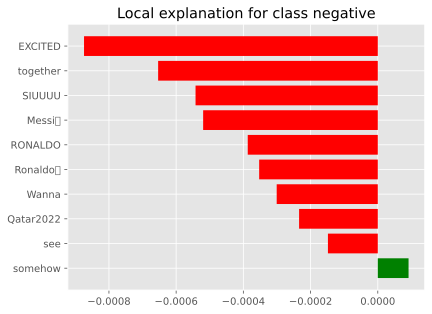

In [59]:
fig = explanation.as_pyplot_figure()

In [63]:
explanation.as_list()[0][1]

-0.000874116441218495